In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from scipy.spatial import distance
from scipy.stats import pearsonr
from scipy.stats import fisher_exact
from scipy.stats.contingency import crosstab
from scipy.stats import hypergeom
from sklearn.manifold import TSNE
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import os


from spec2vec import Spec2Vec
from matchms import calculate_scores

from openeye import oechem

os.chdir('../raw_data')

#### Functions to load and or write to pickle files

In [2]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

# Assess Prediction Performance

##### Predict Structure from spectra Embeddings

1. Calculate:

    1. Euclidean Distance
    2. Cosine Distance
    3. Correlation

2. Calculate Tanimoto score of top scoring hits based on the above metric

3. Sample a few structures to draw

In [3]:
def predict(subject_df,query_df,\
            subject_method,dims,
            metric='euc',
           query_method='sdl'): #both dfs should have z1 and z2 coloumns

    preds = {}
    
    for query_index, query in enumerate(tqdm(query_df[f'{query_method}_z1'])): #(query z1)
        
        #calculate tanimotos if it does not meet threshold;pass
        
        #query = query_df.loc[query_index,'z1']
        preds[query_index] = []
        for subject in subject_df[f'{subject_method}_z2']:#(subject z2)
        
            #subject = subject_df.loc[subject_index,'z2']
            if metric == 'corr':
                corr = pearsonr(query[:dims], subject[:dims])[0]
                preds[query_index].append(corr)
        
            if metric== 'euc':
                euc = distance.euclidean(query[:dims], subject[:dims])
                preds[query_index].append(euc)
        
            if metric == 'cos':
                cos = distance.cosine(query[:dims], subject[:dims])
                preds[query_index].append(cos)
    
    return preds
    

In [4]:
def embedding_similarity(hits, 
                         query_df,
                         subject_df,
                         method='ms2ds_vs_mol2vec'):
    
    
    embed_cos = []
    
    
    for query_index, subject_index in  hits.items():
        
#         if query_df['sdl_tanis'].iloc[query_index] < 0.8: # only needed when testing known analogues
#             continue

        # calculates cosine distance between the spec2vec query embeddings and mol2vec top hit embeddings
        if method == 'ms2ds_vs_mol2vec':
            spec_embed = query_df['ms2ds'].iloc[query_index]
            structure_embed = subject_df['mol2vec'].iloc[subject_index[0][0]]
        
            cos = distance.cosine(spec_embed, structure_embed[:200]) #len of mol2vec is 300 while ms2deepscore is 200
            embed_cos.append(cos)
        
        # calculates cosine distance between the spec2vec query embeddings and spec2vec top hit embeddings
        elif method == 'spec2vec_vs_spec2vec':
            spec_embed = query_df['spec2vec'].iloc[query_index]
            structure_embed = subject_df['spec2vec'].iloc[subject_index[0][0]]
        
            cos = distance.cosine(spec_embed, structure_embed) 
            embed_cos.append(cos)
            
        elif method == 'ms2ds_vs_ms2ds':
            spec_embed = query_df['ms2ds'].iloc[query_index]
            structure_embed = subject_df['ms2ds'].iloc[subject_index[0][0]]
        
            cos = distance.cosine(spec_embed, structure_embed) 
            embed_cos.append(cos)
        
        # calculates cosine distance between the mol2vec query embeddings and mol2vec top hit embeddings
        
        elif method == 'mol2vec_vs_mol2vec':
            spec_embed = query_df['mol2vec'].iloc[query_index]
            structure_embed = subject_df['mol2vec'].iloc[subject_index[0][0]]
        
            cos = distance.cosine(spec_embed, structure_embed) 
            embed_cos.append(cos)
            
       
    return embed_cos
        
    

In [5]:
# function to calculate pairwise tanimoto scores
def tanimoto(smi1, smi2):
    #molecule
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    #fingerprint
    fp1 = Chem.RDKFingerprint(mol1)
    fp2 = Chem.RDKFingerprint(mol2)
    
    #similarity
    score = round(DataStructs.FingerprintSimilarity(fp1,fp2),4)
    return score

In [6]:
# function to calculate tanimoto scores for n hits returns a max tanimotos and {query:top_hit}
def get_tanimotos(preditions_dict,
                  subject_df,
                  query_df, 
                  metric,nn=20,
                 calculate_mcs=False):
    tanimotos = []
    pred = {} #key is the query index, value is the top hit index
    mcs = []
    for query_index, values in tqdm(preditions_dict.items()): # values == score(corr, euc or cosine)
        pred[query_index] = []
        
#         if query_index > 199:
#             break
        
        #select top n hits for each query based on correlation
        if metric == 'corr':
            top_hits = np.sort(values)[::-1][:nn] # higher corr the better
            
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            top_hits_mcs = []
            subject_hit_indices = []
            for hit in top_hits:
                
                subject_index = values.index(hit)
                subject_hit_indices.append(subject_index) #to trace the index of the hits
                    
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                
                top_hits_scores.append(tanimoto(smile1,smile2))
                
                if calculate_mcs: # this guy takes forever so you may want to run tanis only
                    top_hits_mcs.append(mcs_score(smile1,smile2))
                #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
            
            if calculate_mcs:
                mcs.append(max(top_hits_mcs))
                pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)], #hit index based on tanimotos
                                      subject_hit_indices[np.argmax(top_hits_mcs)], #hit index based on mcs
                                      max(top_hits_scores),max(top_hits_mcs)]) #appends [top hit index,tanimoto, msc]
            else:
                pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)], #hit index based on tanimotos
                                       #hit index based on mcs
                                      max(top_hits_scores)])
            
        #select closest n hits for each query based on cosine/euclidian distance
        else: #may be elif metric != 'corr'
            top_hits = np.sort(values)[:nn] #if its euc or cos; the lower the better
            #print(top_hits)
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = [] #for tanimoto
            top_hits_mcs = [] # for mcs
            subject_hit_indices = []
            for hit in top_hits:
                
                #print(hit)
                
                subject_index = values.index(hit)
                subject_hit_indices.append(subject_index) #to trace the index of the hits
                    
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                
                #calculate similarity scores
                top_hits_scores.append(tanimoto(smile1,smile2))
                
                if calculate_mcs: # this guy takes forever so you may want to run tanis only
                    top_hits_mcs.append(mcs_score(smile1,smile2))
            
            #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
            
            if calculate_mcs:
                mcs.append(max(top_hits_mcs))
                pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)], #hit index based on tanimotos
                                      subject_hit_indices[np.argmax(top_hits_mcs)], #hit index based on mcs
                                      max(top_hits_scores),max(top_hits_mcs)]) #appends [top hit index,tanimoto, msc]
            else:
                pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)], #hit index based on tanimotos
                                       
                                      max(top_hits_scores) # tanimoto
                                          
                                         ] 
                                        )
                
        
    return [tanimotos,mcs], pred
    
    

In [7]:
def random_tanimoto(preditions_dict,
                subject_df,query_df):
    tanimotos = []
    
    for query_index, values in preditions_dict.items():
        subject_index = random.randint(0,len(values)) #randomly pick subject index as hits
        
        smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
        smile2 = query_df['smiles'].iloc[query_index]#extract the query smile 
        
        tanimotos.append(tanimoto(smile1,smile2))
    return tanimotos
        
        

In [8]:
# function to extract the query and subject molecule, its legend(class_tanimoto_with the hit), can also return tanis
def pick_hit_mols(hits_dict, 
              train_df,test_df,
              group=None,
              return_tanimoto=False,
              k=2,
              filterby='inchikey14', #if group == [cf_class], set filterby to 'cf_class'
              ): 
    query_mols = []
    hits_mols = []
    tanimoto = []
   
    query_labels = []
    hit_labels = []
    for query_index, subject_index in  hits_dict.items():
    
    
        query_smile = test_df['smiles'].iloc[query_index]
        query_class = test_df['cf_class'].iloc[query_index]
        query_inchi = test_df['inchikey14'].iloc[query_index]
        
        if group:
            
            if filterby == 'cf_class':
                if query_class not in group:
                    continue
            else:
                if query_inchi not in group:
                    continue
    
        if type(query_class) == float:
            query_class = 'NAN'
            #classes = [f'Query:\t{query_class}',]
    
        query_labels.append(f'Query_{query_index}: {query_class}')#else
    
        query = Chem.MolFromSmiles(query_smile)
    
        subject_smile = train_df['smiles'].iloc[subject_index[0][0]]
        subject = Chem.MolFromSmiles(subject_smile)
        cl = train_df['cf_class'].iloc[subject_index[0][0]]
        if type(cl) == float:
            cl = 'NAN'
        subject_class = f'\tHit_{query_index}: {cl}:\tTanimoto: {subject_index[0][1]}'
        #print(query_class,subject_class)
        hit_labels.append(subject_class)
        query_mols.append(query)
        hits_mols.append(subject) #to expand later to include top 5 hits
        tanimoto.append(subject_index[0][1])
        
        
         
    
    if return_tanimoto:
        return [query_mols, hits_mols],[query_labels,hit_labels],tanimoto
    else:
        return [query_mols, hits_mols],[query_labels,hit_labels]

In [9]:
#plot the distribution of the three top tanimotos from the three metrics
def plot_distribution(values, title,
                      savefig=False,
                      legends=None,xlab=None,
                      ylab=None,
                      palette = None,
                      fig_path=None
                     ):
    
    for i, val in enumerate(values):
        if palette:
            ax=sns.kdeplot(x=val, color=palette[i],shade=False)
            
        else:
            ax=sns.kdeplot(x=val,shade=True)
    
    plt.legend(labels=legends, loc='center left', fontsize=12)
    plt.xlabel(xlab, fontsize=15)
    plt.ylabel(ylab, fontsize=15)
    plt.title(label=title, fontsize=15)
    
    if savefig and fig_path:
        plt.savefig(fig_path,\
               transparent=False,bbox_inches = 'tight')
    plt.show()

In [10]:
def mcs_score(query_smile, target_smile, threshold=0.9):
    
    query_mol = Chem.MolFromSmiles(query_smile)
    target_mol = Chem.MolFromSmiles(target_smile)# will be a list later
    mols = [query_mol, target_mol]
    mcs = rdFMCS.FindMCS(mols,
                    completeRingsOnly=True,#should the ring be complete?  
                    ringMatchesRingOnly=False, #should ring atoms match elsewhere?
                    timeout=10, #timeout in seconds; Not exhaustive search
                    threshold=threshold,
                    )
    shared_atoms = mcs.numAtoms/query_mol.GetNumAtoms() # what fraction of atoms is shared between the query and hit
    
    # escape zerodivion error detected after running 93% in 12hrs ):
    try:
        shared_bonds = mcs.numBonds/query_mol.GetNumBonds()
    except ZeroDivisionError:
        shared_bonds = 0 # what fraction of bonds is shared between the query and hit
    
    score = (shared_atoms+(shared_bonds/100)) # following openeye chem library
    
    return round(score, 4)

In [11]:
def spec2vec_similarity(model_path,
                        query_spectrum, 
                        target_spectrum,
                        n_decimals=2):
        
        spectrum_documents = spec_documents = [SpectrumDocument(s, n_decimals=n_decimals)\
                              for s in spectra]
        model = gensim.models.Word2Vec.load(model_path)
        
        # Define similarity_function
        spec2vec_similarity = Spec2Vec(model=model, intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)
        # Calculate scores on all combinations of reference spectrums and queries
        score = calculate_scores(query_spectra, 
                                  target_spectra, 
                                  spec2vec_similarity)
        
        return score

<h1> Compute predictions from the final model <h1>

In [12]:
paths = ['./sdl_logs/sdl_optimized_params/train_df_max3_sdl_and_cca_final_model_z_scores.pickle',
         './sdl_logs/sdl_optimized_params/test_df_max3_sdl_and_cca_final_model_z_scores.pickle',
         #'./sdl_logs/sdl_optimized_params/val_df_max3_sdl_and_cca_final_model_z_scores.pickle'
        ]


train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()
test_df.head(3)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,cca_z1,cca_z2,sdl_z1,sdl_z2
5625,COc1ccc(cc1OC)C(=O)NCc2ccc(OCCN(C)C)cc2,QQQIECGTIMUVDS-UHFFFAOYSA-N,QQQIECGTIMUVDS,spec_id5019,"[0.7660381606480904, -2.9954168988462215, -12....","[0.0, 13.000274658203125, 0.35151147842407227,...","[-0.45550603, -3.2559516, -3.0893652, 5.457150...",Benzene and substituted derivatives,"[0.051531734505366716, -0.6290144322258142, 0....","[-0.3670569538963088, -0.7741333930951451, 0.1...","[-0.5074534, -0.19799042, -0.084220506, -0.090...","[-1.2729512, -0.20587964, -0.22160338, -0.5555..."
40023,COc1cc(OC)c2c(OC)c(-c3ccc4c(c3)OCO4)c(=O)oc2c1,PZYZNVLXKYMURF-UHFFFAOYSA-N,PZYZNVLXKYMURF,spec_id39710,"[4.160680518910307, -17.534900146210205, -20.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 63.7232666015625, 5....","[1.2124093, -3.7327924, -5.30343, 5.8895183, 0...",Isoflavonoids,"[-0.5501047970153369, 0.38237380309998087, 0.3...","[-0.4201982466143634, -0.10796739849747246, -0...","[1.0821751, -0.21904153, -0.2859266, 0.8517396...","[0.7512287, -0.21170664, -0.1404785, 1.031399,..."
32710,O=C2C(O)=C(OC=3C=C(OC1OC(CO)C(O)C(O)C1(O))C(OC...,AFCDXKGLUDDXCK-UHFFFAOYSA-N,AFCDXKGLUDDXCK,spec_id31385,"[4.156373062713153, 2.6467714749778737, -9.709...","[25.13886260986328, 20.056901931762695, 0.0, 0...","[3.884097, -4.328525, -8.565995, 3.9552908, 1....",Flavonoids,"[-0.0658633840961331, 0.9429675883808374, -1.8...","[-0.20775599360091013, 0.7636143826091808, -1....","[1.8711135, -0.21995814, -0.53303856, 1.526128...","[1.8491485, -0.2038337, -0.060643416, 1.56308,..."


In [12]:
metrics = ['cos', 'corr', 'euc']

models = ['sdl', 'cca']
size = 5
for metric in metrics:
    for model in models:
        print(f'\nModel {model}')
        # cosine distance
        dist = predict(subject_df=train_df,\
                        query_df=test_df.head(size),dims=100,
                        subject_method=f'{model}', # base name of z scores cols in subject df
                       query_method=f'{model}', # base name of z scores cols in query df
                       metric=metric)
    
        print('\nComputing Distance is Completed successfully\n')
       # tanimotos and hits
        scores, hit = get_tanimotos(dist,subject_df=train_df,\
                                    query_df=test_df.head(size),\
                                    metric=metric)
    
        print('\nComputing Tanimoto and hits is Completed successfully\n')
        # write the distances to file
        Files(f'./sdl_logs/sdl_optimized_params/{model}_preds/{model}_final_model_test_{metric}.pickle').write_to_file(dist)
    
        del dist # rescue memory :) 
    
        Files(f'./sdl_logs/sdl_optimized_params/{model}_preds/{model}_final_model_test_{metric}_tanimoto.pickle').write_to_file(scores[0]) # scores has [tanimoto, mcs]
        Files(f'./sdl_logs/sdl_optimized_params/{model}_preds/{model}_final_model_test_{metric}_hits.pickle').write_to_file(hit)
    
        del scores, hit # only load when actually using them.

<h2> Load DeepCCA Tanimoto scores from the final models </h2>

In [17]:
metrics = ['cos', 'corr', 'euc']

models = ['sdl', 'cca']
size = 5
tanis_dict = {}
for metric in metrics:
    tanis_dict[metric] = []
    for model in models:
        tani = Files(f'./sdl_logs/sdl_optimized_params/{model}_preds/{model}_final_model_test_{metric}_tanimoto.pickle').load_pickle()
        tanis_dict[metric].append(tani)
        

In [21]:
tani = Files(f'./sdl_logs/sdl_optimized_params/sdl_preds/sdl_final_model_test_cos_tanimoto_dim_20.pickle').load_pickle()
        
np.mean(tani)

0.5500593124246079

In [34]:
tanis_dict.keys()

dict_keys(['cos', 'corr', 'euc'])

In [44]:
len(tanis_dict['cos'][0])

8290

<h2> Plot Tanimots computed from Cosine, Correlation and Euclidean metric </h2>

In [56]:
deepcca_tanis_df = pd.DataFrame({'cosine_DeepCCA': tanis_dict['cos'][0],
                                 'correlation_DeepCCA': tanis_dict['corr'][0],
                                 'euclidean_DeepCCA': tanis_dict['euc'][0],
                                 #'cosine_CCA': tanis_dict['cos'][1],
                                 #'correlation_CCA': tanis_dict['corr'][1],
                                 #'euclidean_CCA': tanis_dict['euc'][1],
                                })
deepcca_tanis_df.head()

,cosine_DeepCCA,correlation_DeepCCA,euclidean_DeepCCA
0,0.5215,0.5215,0.5304
1,0.4381,0.4381,0.4381
2,0.8913,0.8913,0.8913
3,0.9497,0.9497,0.9497
4,0.6005,0.5995,0.5941


C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


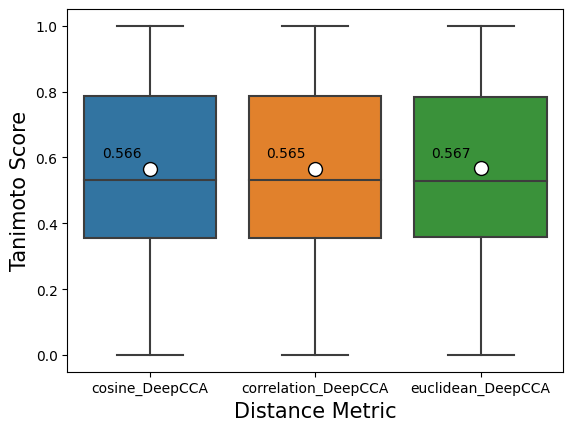

In [62]:
#palette = [sns.color_palette("colorblind")[0],
           #sns.color_palette("colorblind")[5],
           #sns.color_palette("colorblind")[6],
                 
          #] #random
plt.figure(figsize=(6.4, 4.8),dpi=100)
ax = sns.boxplot(data=deepcca_tanis_df,
             showmeans = True,
           meanprops={"marker":"o",
                      "markerfacecolor":"white", 
                      "markeredgecolor":"black",
                      "markersize":"10"})
#plt.legend(labels=list(deepcca_tanis_df.columns),loc=(1.04, 0.6))
#add mean tanimoto on the plot
plt.text(x=-0.29,y=0.6,s=round(np.mean(tanis_dict['cos'][0]),3))
plt.text(x=0.7,y=0.6,s=round(np.mean(tanis_dict['corr'][0]),3))
plt.text(x=1.7,y=0.6,s=round(np.mean(tanis_dict['euc'][0]),3))
plt.xlabel('Distance Metric', fontsize=15)
plt.ylabel('Tanimoto Score', fontsize=15)

# plt.text(x=2.7,y=0.6,s=round(np.mean(tanis_dict['cos'][1]),3))
# plt.text(x=3.7,y=0.6,s=round(np.mean(tanis_dict['corr'][1]),3))
# plt.text(x=4.7,y=0.55,s=round(np.mean(tanis_dict['euc'][1]),3))
# ax.set_xticklabels([' ',' ',' ',' ',' ',' ' ])

plt.show()

### Load df with SDL and CCA 15 dims z transformations

(These are for the current best model)

In [22]:
# paths = ['./max3_sdl_dims_10_best_train_df_with_z.pickle','./max3_sdl_dims_10_test_df_with_z.pickle']
# train_df = Files(paths[0]).load_pickle()
# test_df = Files(paths[1]).load_pickle()
# hits_sdl = Files('./max3_sdl_hits_dims_10.pickle').load_pickle()
# hits_cca = Files('./max3_cca_hits_dims_10.pickle').load_pickle()


#testing cca and sdl_768

paths = ['./sdl_768_15_dims/max3_sdl_cca_dims_15_train_df_with_z.pickle',
        './sdl_768_15_dims/max3_sdl_cca_dims_15_test_df_with_z.pickle',
        './sdl_768_15_dims/max3_sdl_cca_dims_15_val_df_with_z.pickle']

train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()
val_df = Files(paths[2]).load_pickle()
val_df.head(2)

# hits
hits_sdl = Files('./sdl_768_15_dims/sdl_768_15_dims_cos_hits_test_df').load_pickle()
hits_cca = Files('./cca_15_dims/cca_15_dims_cos_hits_test_df').load_pickle()

# tanis
sdl_tanis = Files('./sdl_768_15_dims/sdl_768_15_dims_cos_tanis_test_df').load_pickle()
cca_tanis = Files('./cca_15_dims/cca_15_dims_cos_tanis_test_df').load_pickle()

#cosine distance
sdl_cos = Files('./sdl_768_15_dims/sdl_768_15_dims_cos_test_df').load_pickle()
cca_cos = Files('./cca_15_dims/cca_15_dims_cos_test_df').load_pickle()

## 1. Calculate the predictions from each of the loaded models (different batch sizes)

#### Step 1.1: load the dfs with DeepCCA transformations (z scores)

In [ ]:
paths = ['./sdl_logs/sdl_optimal_batch_size/train_df_max3_sdl_and_cca_batch_128_to_768_15_dim_z',
         './sdl_logs/sdl_optimal_batch_size/test_df_max3_sdl_and_cca_batch_128_to_768_15_dim_z',
        #'./sdl_logs/sdl_optimal_dims/val_df_max3_sdl_dims_optimised_z_scores.pickle'
        ]

train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle() # using validation set as computing MCS is quite slow

##### Step 1.2: Compute cosine distance and tanimotos

In [148]:
%%time

dims = 25
#size = 1000
metric = 'cos' 


methods = ['sdl_128','sdl_256','sdl_384','sdl_512','sdl_640', 'sdl_768'] #models

for method in methods:
    dist = predict(subject_df=train_df,
                    query_df=test_df,dims=dims,
                    subject_method=method,
                    query_method = method,                   
                    metric='cos')
    
    scores, hit = get_tanimotos(dist,subject_df=train_df,\
                                query_df=test_df.head(size),\ # run only 1000 be sure to run the whole
                                    metric='cos')
    # write to file as it generates
    Files(f'./sdl_logs/sdl_optimal_batch_size/preds/{method}_test_cosine_distance.pickle').write_to_file(dist)
    Files(f'./sdl_logs/sdl_optimal_batch_size/preds/{method}_test_tanimoto.pickle').write_to_file(scores[0]) # scores has [tanimoto, mcs]
    Files(f'./sdl_logs/sdl_optimal_batch_size/preds/{method}_test_mcs.pickle').write_to_file(scores[1])
    Files(f'./sdl_logs/sdl_optimal_batch_size/preds/{method}_test_hits.pickle').write_to_file(hit)
    del dist, scores, hit
    print(f'{dim} COMPLETE')


[16:38:19] WARNING: not removing hydrogen atom without neighbors


Wall time: 26min 36s


##### Step 1.3: Load Tanimoto from each model with different bach size

In [ ]:
methods = ['sdl_128','sdl_256','sdl_384','sdl_512','sdl_640', 'sdl_768'] #models

tanis = []
for method in methods:
    tani = Files(f'./sdl_logs/sdl_optimal_batch_size/preds/{method}_test_tanimoto.pickle').load_pickle()
    tanis.append(tani)

##### Step 1.4: plot Tanis distribution

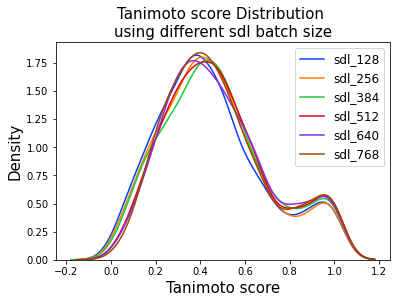

In [149]:
palette = sns.color_palette("bright") 
           
for i, tan in enumerate(tanis):
    ax=sns.kdeplot(x=tan,color = palette[i],shade=False)
plt.legend(labels=methods, loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution \nusing different sdl batch size', fontsize=15)
# plt.savefig(f'../plots/max3_tanimoto_euc_distribution.png',\
#            transparent=False,bbox_inches = 'tight')
plt.show()

## 2. Calculate the predictions from each of the loaded models (different dimensions)

##### Step 2.1: load the dfs with DeepCCA transformations (z scores)

In [26]:
paths = ['./sdl_logs/sdl_optimal_dims/train_df_max3_sdl_dims_optimised_z_scores.pickle',
         #'./sdl_logs/sdl_optimal_dims/test_df_max3_sdl_dims_optimised_z_scores.pickle',
        './sdl_logs/sdl_optimal_dims/val_df_max3_sdl_dims_optimised_z_scores.pickle'
        ]

train_df = Files(paths[0]).load_pickle()
val_df = Files(paths[1]).load_pickle() # using validation set as computing MCS is quite slow

##### Step 2.2: Compute cosine distance and tanimotos

In [16]:
%%time
#size = 100
dims  = [10,20,30,40,50] # for some reason 50 dims crushed
for dim in dims:
    dist = predict(subject_df=train_df,\
                        query_df=val_df,dims=dim,
                        method=f'sdl_dims_{dim}', metric='cos')
    
#     load from file
    
#     dist = Files(f'./sdl_logs/sdl_optimal_dims/sdl_dim_{dim}_cosine_distance.pickle').load_pickle()
    
   
    
    scores, hit = get_tanimotos(dist,subject_df=train_df,\
                                query_df=val_df,\
                                    metric='cos')
    # write to file as it generates
    Files(f'./sdl_logs/sdl_optimal_dims/validation/sdl_dim_{dim}_validation_cosine_distance.pickle').write_to_file(dist)
    Files(f'./sdl_logs/sdl_optimal_dims/validation/sdl_dim_{dim}_validation_tanimoto.pickle').write_to_file(scores[0]) # scores has [tanimoto, mcs]
    Files(f'./sdl_logs/sdl_optimal_dims/validation/sdl_dim_{dim}_validation_mcs.pickle').write_to_file(scores[1])
    Files(f'./sdl_logs/sdl_optimal_dims/validation/sdl_dim_{dim}_validation_hits.pickle').write_to_file(hit)
    del dist, scores, hit
    print(f'{dim} COMPLETE')
  
    
    
   

##### Step 2.3: Load Tanimoto and MCS from dimension optimised models

In [15]:
dims = [10,20,30,40,50,100,200,300] # 50 not included as this is still running
tanis = []
mcs_all = []

for dim in dims:
    tani = Files(f'./sdl_logs/sdl_optimal_dims/validation/sdl_dim_{dim}_validation_tanimoto.pickle').load_pickle()
    #mcs = Files(f'./sdl_logs/sdl_optimal_dims/validation/sdl_dim_{dim}_validation_mcs.pickle').load_pickle()
    tanis.append(tani)
   # mcs_all.append(mcs)
    print('complete dim:', dim)
    #break

complete dim: 10
complete dim: 20
complete dim: 30
complete dim: 40
complete dim: 50
complete dim: 100
complete dim: 200
complete dim: 300


##### Step 2.4: Compare Tanimoto vs MCS

In [18]:
# bundle them into df
tanis_df = pd.DataFrame({'10': tanis[0],#+mcs_all[0],
                         '20': tanis[1],#+mcs_all[1],
                         '30': tanis[2],#+mcs_all[2],
                         '40': tanis[3],#+mcs_all[3],
                         '50': tanis[4],
                         '100': tanis[5],
                         '200': tanis[6],
                         '300': tanis[7],
                         
                        #'score' :  ['Tanis',]*len(tanis[0])+ ['MCS',]*len(mcs_all[0])

                       })


# mcs_df = pd.DataFrame({'dims_10': mcs_all[0],#+mcs_all[0],
#                        'dims_20': mcs_all[1],#+mcs_all[1],
#                        'dims_30': mcs_all[2],#+mcs_all[2],
#                        'dims_40': mcs_all[3],#+mcs_all[3],
#                        'dims_50': mcs_all[4]
#                         #'score' :  ['Tanis',]*len(tanis[0])+ ['MCS',]*len(mcs_all[0])

#                        })


###### Plot Tanis

C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


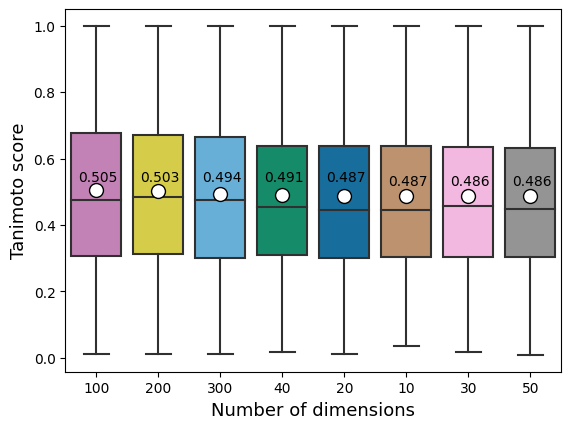

In [35]:
#plot Tanimoto sorted by mean
sorted_index = tanis_df.mean().sort_values(ascending=False).index
tanis_df_sorted=tanis_df[sorted_index]

#set pallete
palette = [sns.color_palette("colorblind")[4],
           sns.color_palette("colorblind")[8],
           sns.color_palette("colorblind")[9],
           sns.color_palette("colorblind")[2],
           sns.color_palette("colorblind")[0],
           sns.color_palette("colorblind")[5],
           sns.color_palette("colorblind")[6],
           sns.color_palette("colorblind")[7],
            
           ]
           #sns.color_palette("colorblind")[3], #CCA
plt.figure(figsize=(6.4, 4.8),dpi=100)
sns.boxplot(data=tanis_df_sorted, showmeans = True,
            palette = palette,
           meanprops={"marker":"o",
                      "markerfacecolor":"white", 
                      "markeredgecolor":"black",
                      "markersize":"10"})
plt.xlabel('Number of dimensions', fontsize=13)
plt.ylabel('Tanimoto score', fontsize=13)

#add mean tanimoto on the plot
plt.text(x=-0.29,y=0.53,s=round(np.mean(tanis[5]),3))
plt.text(x=0.7,y=0.53,s=round(np.mean(tanis[6]),3))
plt.text(x=1.7,y=0.53,s=round(np.mean(tanis[7]),3))
plt.text(x=2.7,y=0.53,s=round(np.mean(tanis[3]),3))
plt.text(x=3.7,y=0.53,s=round(np.mean(tanis[1]),3))
plt.text(x=4.7,y=0.52,s=round(np.mean(tanis[0]),3))
plt.text(x=5.7,y=0.52,s=round(np.mean(tanis[2]),3))
plt.text(x=6.7,y=0.52,s=round(np.mean(tanis[4]),3))
plt.show()

###### Plot MCS

C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


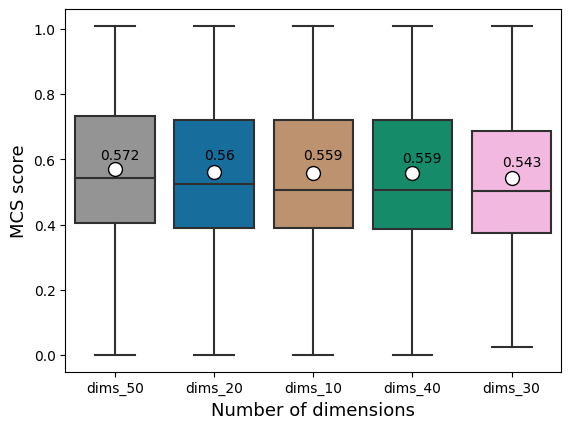

In [184]:
sorted_index = mcs_df.mean().sort_values(ascending=False).index
mcs_df_sorted=mcs_df[sorted_index]
#set pallete
palette = [sns.color_palette("colorblind")[7],
           sns.color_palette("colorblind")[0],
           sns.color_palette("colorblind")[5],
           sns.color_palette("colorblind")[2],
           sns.color_palette("colorblind")[6],]
plt.figure(figsize=(6.4, 4.8),dpi=100)
sns.boxplot(data=mcs_df_sorted , showmeans = True,
            palette=palette,
           meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})

plt.xlabel('Number of dimensions', fontsize=13)
plt.ylabel('MCS score', fontsize=13)



#add mean MCS on the plot
plt.text(x=-0.15,y=0.6,s=round(np.mean(mcs_all[4]),3))
plt.text(x=0.9,y=0.6,s=round(np.mean(mcs_all[1]),3))
plt.text(x=1.9,y=0.6,s=round(np.mean(mcs_all[0]),3))
plt.text(x=2.9,y=0.59,s=round(np.mean(mcs_all[3]),3))
plt.text(x=3.9,y=0.58,s=round(np.mean(mcs_all[2]),3))
plt.show()

## 3. Calculate the predictions from each of the loaded models (different layers)

##### Step 3.1: load the dfs with DeepCCA transformations (z scores)

In [14]:
paths = ['./sdl_logs/sdl_optimal_layers/train_df_max3_sdl_layers_optimised_z_scores.pickle',
        './sdl_logs/sdl_optimal_layers/test_df_max3_sdl_layers_optimised_z_scores.pickle',
        #'./sdl_logs/sdl_optimal_dims/val_df_max3_sdl_layers_optimised_z_scores.pickle'
        ]

train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()

##### Step 3.2: Compute cosine distance and tanimotos

In [ ]:
%%time
#compute cosine distance
#size = 10

for i in range(1,6): # since we have 5 models with different num layers
    print(f'\nLAYERS {i}')
    # cosine distance
    dist = predict(subject_df=train_df,\
                    query_df=test_df,dims=15,
                    subject_method=f'sdl_layers_{i}', # base name of z scores cols in subject df
                   query_method=f'sdl_layers_{i}', # base name of z scores cols in query df
                   metric='cos')
    
    print('\nComputing Distance is Completed successfully\n')
   # tanimotos and hits
    scores, hit = get_tanimotos(dist,subject_df=train_df,\
                                query_df=test_df,\
                                    metric='cos')
    
    print('\nComputing Tanimoto and hits is Completed successfully\n')
    # write to file as it generates
    Files(f'./sdl_logs/sdl_optimal_layers/preds/sdl_layers_{i}_test_cosine.pickle').write_to_file(dist)
    
    del dist # rescue memory
    
    Files(f'./sdl_logs/sdl_optimal_layers/preds/sdl_layers_{i}_test_tanimoto.pickle').write_to_file(scores[0]) # scores has [tanimoto, mcs]
    Files(f'./sdl_logs/sdl_optimal_layers/preds/sdl_layers_{i}_test_hits.pickle').write_to_file(hit)
    
    del scores, hit 
    
    
  


LAYERS 1


100%|█████████████████████████████████████████████████████████████████████████████| 8290/8290 [1:55:13<00:00,  1.20it/s]



Computing Distance is Completed successfully



100%|███████████████████████████████████████████████████████████████████████████████| 8290/8290 [08:36<00:00, 16.06it/s]



Computing Tanimoto and hits is Completed successfully


LAYERS 2


100%|█████████████████████████████████████████████████████████████████████████████| 8290/8290 [1:55:36<00:00,  1.20it/s]



Computing Distance is Completed successfully



100%|███████████████████████████████████████████████████████████████████████████████| 8290/8290 [08:39<00:00, 15.97it/s]



Computing Tanimoto and hits is Completed successfully


LAYERS 3


 43%|████████████████████████████████▋                                            | 3524/8290 [49:01<1:07:09,  1.18it/s]

##### Step 3.3: load computed Tanimotos

In [116]:
layers_tanis = []
for i in range(1,6):
    tani = Files(f'./sdl_logs/sdl_optimal_layers/preds/sdl_layers_{i}_test_tanimoto.pickle').load_pickle()
    layers_tanis.append(tani)
    #print(f'Loading Layer {i} Tanis Complete')
    #break
    print(f'Layer {i} # Correct hits: {tani.count(1.0)}')
len(layers_tanis[0])

Layer 1 # Correct hits: 228
Layer 2 # Correct hits: 291
Layer 3 # Correct hits: 238
Layer 4 # Correct hits: 212
Layer 5 # Correct hits: 125


8290

In [24]:
len(layers_tanis[3])

8290

In [151]:
layers_df = pd.DataFrame({'1':layers_tanis[0],
                       '2':layers_tanis[1],
                       '3':layers_tanis[2],
                       '4':layers_tanis[3],
                       '5':layers_tanis[4],
                         })
layers_df.head(5)

,1,2,3,4,5
0,0.3401,0.5363,0.5363,0.4090,0.2482
1,0.4432,0.4228,0.4624,0.4344,0.4436
2,0.8565,0.8445,0.8872,0.9394,0.8455
3,0.9329,0.4059,0.3847,0.8322,0.4585
4,0.5958,0.6030,0.6030,0.6030,0.5313


##### Step 3.4: Compare the Tanis from different Layers

C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


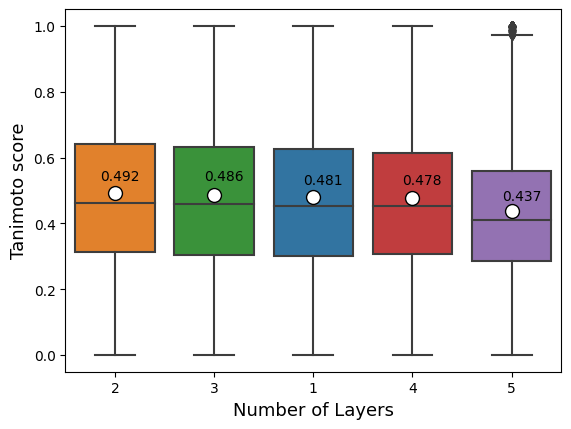

In [160]:
sorted_index = layers_df.mean().sort_values(ascending=False).index
layers_df_sorted=layers_df[sorted_index]

palette = [sns.color_palette()[1],
           sns.color_palette()[2],
           sns.color_palette()[0],
           sns.color_palette()[3],
           sns.color_palette()[4],
          ]

#palette = ['orange', 'green', 'blue', 'red', 'purple']
plt.figure(figsize=(6.4, 4.8),dpi=100)
sns.boxplot(data=layers_df_sorted,
            palette=palette,
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
#plt.title(label='Cosine distance between embeddings before and after Deep(CCA)\n')
plt.xlabel('Number of Layers', fontsize=13)
plt.ylabel('Tanimoto score', fontsize=13)
#add mean tanimoto on the plot
plt.text(x=-0.15,y=0.53,s=round(np.mean(layers_tanis[1]),3))
plt.text(x=0.9,y=0.53,s=round(np.mean(layers_tanis[2]),3))
plt.text(x=1.9,y=0.52,s=round(np.mean(layers_tanis[0]),3))
plt.text(x=2.9,y=0.52,s=round(np.mean(layers_tanis[3]),3))
plt.text(x=3.9,y=0.47,s=round(np.mean(layers_tanis[4]),3))
plt.show()

## 4. Calculate the predictions from each of the loaded models (different layer size)

In [13]:
# load the dfs
paths = ['./sdl_logs/sdl_optimal_layer_size/train_df_max3_sdl_layer_size_optimised_z_scores.pickle',
        './sdl_logs/sdl_optimal_layer_size/test_df_max3_sdl_layer_size_optimised_z_scores.pickle',
                #'./sdl_logs/sdl_optimal_dims/val_df_max3_sdl_layers_optimised_z_scores.pickle'
                ]

train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()
test_df.head(1) # have we loaded the right dfs? 

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,layer_size_top_1_z1,layer_size_top_1_z2,layer_size_top_2_z1,layer_size_top_2_z2,layer_size_top_3_z1,layer_size_top_3_z2,layer_size_top_4_z1,layer_size_top_4_z2
5625,COc1ccc(cc1OC)C(=O)NCc2ccc(OCCN(C)C)cc2,QQQIECGTIMUVDS-UHFFFAOYSA-N,QQQIECGTIMUVDS,spec_id5019,"[0.7660381606480904, -2.9954168988462215, -12....","[0.0, 13.000274658203125, 0.35151147842407227,...","[-0.45550603, -3.2559516, -3.0893652, 5.457150...",Benzene and substituted derivatives,"[-0.1577186, -0.3175125, -0.2779696, -0.067580...","[-0.21404436, -0.5933312, -0.3001924, -0.43056...","[-0.34673876, 0.6322149, -0.52254194, 0.008149...","[-0.23976862, 0.3476208, -0.472915, 0.13565256...","[-0.4901716, -0.11326296, -0.32370108, -0.1995...","[0.26509246, -0.2546515, -0.5419992, -0.117207...","[0.32770923, -0.05803679, 1.0009441, -0.068835...","[0.17432554, -0.23875642, 0.9729419, -0.205952..."


In [24]:
%%time
#compute cosine distance

for i in range(4): # since we have 4 models with different hidden layer size
    print(f'\nModel {i+1}')
    # cosine distance
    dist = predict(subject_df=train_df,\
                    query_df=test_df,dims=15,
                    subject_method=f'layer_size_top_{i+1}', # base name of z scores cols in subject df
                   query_method=f'layer_size_top_{i+1}', # base name of z scores cols in query df
                   metric='cos')
    
    print('\nComputing Distance is Completed successfully\n')
   # tanimotos and hits
    scores, hit = get_tanimotos(dist,subject_df=train_df,\
                                query_df=test_df,\
                                    metric='cos')
    
    print('\nComputing Tanimoto and hits is Completed successfully\n')
    # do not write the distance to file; its a huge file and we are still developing our el model
    #Files(f'./sdl_logs/sdl_optimal_layers/preds/sdl_layers_{i}_test_cosine.pickle').write_to_file(dist)
    
    del dist # rescue memory :) 
    
    Files(f'./sdl_logs/sdl_optimal_layer_size/preds/layer_size_top_{i+1}_test_tanimoto.pickle').write_to_file(scores[0]) # scores has [tanimoto, mcs]
    Files(f'./sdl_logs/sdl_optimal_layer_size/preds/layer_size_top_{i+1}_test_hits.pickle').write_to_file(hit)
    
    del scores, hit 

In [19]:
# load tanis
layer_size_tanis = []
for i in range(4):
    tani = Files(f'./sdl_logs/sdl_optimal_layer_size/preds/layer_size_top_{i+1}_test_tanimoto.pickle').load_pickle()
    layer_size_tanis.append(tani)
    #print(f'Loading Layer {i} Tanis Complete')
    #break
    print(f'top {i} model # Correct hits: {tani.count(1.0)}')
len(layer_size_tanis)

top 0 model # Correct hits: 220
top 1 model # Correct hits: 270
top 2 model # Correct hits: 201
top 3 model # Correct hits: 155


4

In [28]:
layers_size_df = pd.DataFrame({'top 1':layer_size_tanis[0],
                       'top 2':layer_size_tanis[1],
                       'bottom 2':layer_size_tanis[2],
                       'bottom 1':layer_size_tanis[3],
                                                })
layers_size_df.shape

(8290, 4)

C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


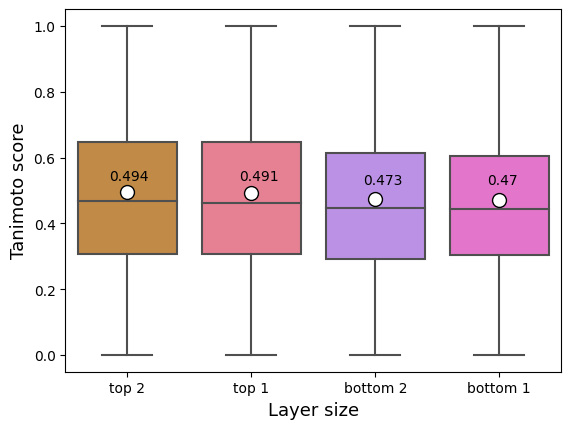

In [31]:
# plot tanis from layer size
sorted_index = layers_size_df.mean().sort_values(ascending=False).index
layers_size_df_sorted=layers_size_df[sorted_index]

palette = [sns.color_palette("husl", 9)[1],
           sns.color_palette("husl", 9)[0],
           sns.color_palette("husl", 9)[7],
           sns.color_palette("husl", 9)[8],
           
          ]


plt.figure(figsize=(6.4, 4.8),dpi=100)
sns.boxplot(data=layers_size_df_sorted,
            palette=palette,
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
#plt.title(label='Cosine distance between embeddings before and after Deep(CCA)\n')
plt.xlabel('Layer size', fontsize=13)
plt.ylabel('Tanimoto score', fontsize=13)


#add mean tanimoto on the plot
plt.text(x=-0.15,y=0.53,s=round(np.mean(layer_size_tanis[1]),3))
plt.text(x=0.9,y=0.53,s=round(np.mean(layer_size_tanis[0]),3))
plt.text(x=1.9,y=0.52,s=round(np.mean(layer_size_tanis[2]),3))
plt.text(x=2.9,y=0.52,s=round(np.mean(layer_size_tanis[3]),3))

plt.show()

## Calculate the predictions from each of the loaded models (different Activations)

In [32]:
# load activation dfs

paths = ['./sdl_logs/sdl_optimal_activation/train_df_max3_sdl_activation_optimised_z_scores.pickle',
        './sdl_logs/sdl_optimal_activation/test_df_max3_sdl_activation_optimised_z_scores.pickle',
                #'./sdl_logs/sdl_optimal_dims/val_df_max3_sdl_layers_optimised_z_scores.pickle'
                ]

train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()
test_df.head(1) # have we loaded the right dfs? 

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,leakyrelu_z1,leakyrelu_z2,relu_z1,relu_z2,sigmoid_z1,sigmoid_z2,tanh_z1,tanh_z2
5625,COc1ccc(cc1OC)C(=O)NCc2ccc(OCCN(C)C)cc2,QQQIECGTIMUVDS-UHFFFAOYSA-N,QQQIECGTIMUVDS,spec_id5019,"[0.7660381606480904, -2.9954168988462215, -12....","[0.0, 13.000274658203125, 0.35151147842407227,...","[-0.45550603, -3.2559516, -3.0893652, 5.457150...",Benzene and substituted derivatives,"[-0.38297227, 0.4132939, -0.16248423, -0.06425...","[-0.014901519, 0.11486686, -0.25672385, -0.809...","[-0.11099778, 0.25115705, 0.5125449, 0.0279953...","[-0.2367633, 0.18926969, 0.72595316, 0.1301444...","[0.39777708, 1.0025584, 0.31936717, -0.8077369...","[-0.077813625, 0.9071562, 0.47526538, -1.05713...","[0.09265125, 0.77603346, 0.7171092, -0.3033709...","[-0.56862116, 0.59277105, -0.53821194, -0.3563..."


In [ ]:

%%time
#compute cosine distance
model_logs = ['leakyrelu', 'relu','sigmoid', 'tanh']


for i, activation in enumerate(model_logs): # since we have 4 models with different activation function
    print(f'\nModel: {activation}')
    # cosine distance
    dist = predict(subject_df=train_df,\
                    query_df=test_df,dims=15,
                    subject_method=f'{activation}', # base name of z scores cols in subject df
                   query_method=f'{activation}', # base name of z scores cols in query df
                   metric='cos')
    
    print('\nComputing Distance is Completed successfully\n')
   # tanimotos and hits
    scores, hit = get_tanimotos(dist,subject_df=train_df,\
                                query_df=test_df,\
                                    metric='cos')
    
    print('\nComputing Tanimoto and hits is Completed successfully\n')
    # do not write the distance to file; its a huge file and we are still developing our el model
    #Files(f'./sdl_logs/sdl_optimal_layers/preds/sdl_layers_{i}_test_cosine.pickle').write_to_file(dist)
    
    del dist # rescue memory :) 
    
    Files(f'./sdl_logs/sdl_optimal_activation/preds/{activation}_test_tanimoto.pickle').write_to_file(scores[0]) # scores has [tanimoto, mcs]
    Files(f'./sdl_logs/sdl_optimal_activation/preds/{activation}_test_hits.pickle').write_to_file(hit)
    
    del scores, hit 


Model: leakyrelu


100%|█████████████████████████████████████████████████████████████████████████████| 8290/8290 [2:27:16<00:00,  1.07s/it]



Computing Distance is Completed successfully



100%|███████████████████████████████████████████████████████████████████████████████| 8290/8290 [09:04<00:00, 15.23it/s]



Computing Tanimoto and hits is Completed successfully


Model: relu


100%|█████████████████████████████████████████████████████████████████████████████| 8290/8290 [2:29:34<00:00,  1.08s/it]



Computing Distance is Completed successfully



100%|███████████████████████████████████████████████████████████████████████████████| 8290/8290 [09:21<00:00, 14.77it/s]



Computing Tanimoto and hits is Completed successfully


Model: sigmoid


100%|█████████████████████████████████████████████████████████████████████████████| 8290/8290 [2:28:30<00:00,  1.07s/it]



Computing Distance is Completed successfully



100%|███████████████████████████████████████████████████████████████████████████████| 8290/8290 [09:06<00:00, 15.16it/s]



Computing Tanimoto and hits is Completed successfully


Model: tanh


 87%|███████████████████████████████████████████████████████████████████▎         | 7249/8290 [2:09:46<18:45,  1.08s/it]

In [33]:
# load tanis from activations
# load tanis
activation_tanis = []
model_logs = ['leakyrelu', 'relu','sigmoid', 'tanh']
for i, activation in enumerate(model_logs):
    tani = Files(f'./sdl_logs/sdl_optimal_activation/preds/{activation}_test_tanimoto.pickle').load_pickle()
    activation_tanis.append(tani)
    #print(f'Loading Layer {i} Tanis Complete')
    #break
    print(f'{activation} model # Correct hits: {tani.count(1.0)}')
len(activation_tanis)

leakyrelu model # Correct hits: 240
relu model # Correct hits: 222
sigmoid model # Correct hits: 279
tanh model # Correct hits: 409


4

In [37]:
activation_df = pd.DataFrame({'leakyrelu':activation_tanis[0],
                       'relu':activation_tanis[1],
                       'sigmoid':activation_tanis[2],
                       'tanh':activation_tanis[3],
                                                })


sorted_index = activation_df.mean().sort_values(ascending=False).index
activation_df_sorted=activation_df[sorted_index]
activation_df_sorted.head(5)

,tanh,leakyrelu,sigmoid,relu
0,0.2927,0.5000,0.5215,0.2931
1,0.3965,0.6805,0.4659,0.4229
2,0.8718,0.8713,0.8836,0.8872
3,0.4002,0.7438,0.8452,0.5317
4,0.5746,0.6030,0.6030,0.6030


C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


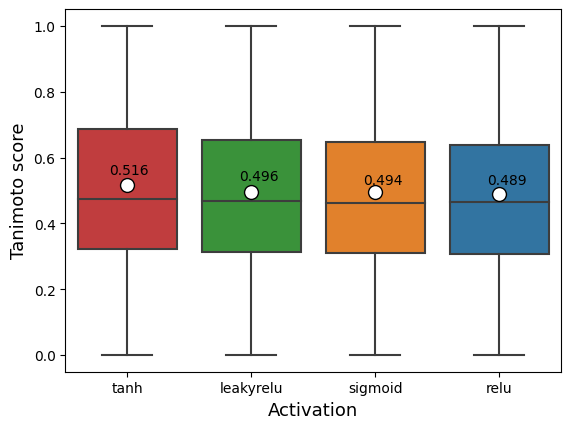

In [45]:
palette = [sns.color_palette()[3],
           sns.color_palette()[2],
           sns.color_palette()[1],
           sns.color_palette()[0],
          ]

plt.figure(figsize=(6.4, 4.8),dpi=100)
sns.boxplot(data=activation_df_sorted,
            palette=palette,
            showmeans = True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
#plt.title(label='Cosine distance between embeddings before and after Deep(CCA)\n')
plt.xlabel('Activation', fontsize=13)
plt.ylabel('Tanimoto score', fontsize=13)

#add mean tanimoto on the plot
plt.text(x=-0.15,y=0.55,s=round(np.mean(activation_tanis[3]),3))
plt.text(x=0.9,y=0.53,s=round(np.mean(activation_tanis[0]),3))
plt.text(x=1.9,y=0.52,s=round(np.mean(activation_tanis[2]),3))
plt.text(x=2.9,y=0.52,s=round(np.mean(activation_tanis[1]),3))
plt.show()

## 4. Calculate query vs hit cosine distance before DeepCCA was applied:

i.e the cosine distance of mol2vec (structure) embeddings of query molecule and spec2vec (spectrum)

##### Step 4.1: Calculate cosine distances before DeepCCA/CCA was applied

In [47]:
%%time
# spec2vec vs mol2vec
ms2ds_vs_mol2vec_before_sdl = embedding_similarity(hits_sdl, test_df,train_df)

Files('./sdl_768_15_dims/ms2ds_and_mol2vec_cosine_distance.pickle').write_to_file(ms2ds_vs_mol2vec_before_sdl)

#mol2vec vs mol2vec
mol2vec_vs_mol2vec_before_sdl = embedding_similarity(hits_sdl, 
                                                     test_df,
                                                     train_df,
                                                    method='mol2vec_vs_mol2vec')

Files('./sdl_768_15_dims/mol2vec_and_mol2vec_cosine_distance_before_deep(cca).pickle').write_to_file(mol2vec_vs_mol2vec_before_sdl)

#ms2ds vs ms2ds
ms2ds_vs_ms2dsc_before_sdl = embedding_similarity(hits_sdl, 
                                                     test_df,
                                                     train_df,
                                                    method='ms2ds_vs_ms2ds')

Files('./sdl_768_15_dims/ms2ds_and_ms2ds_cosine_distance_before_deep(cca).pickle').write_to_file(ms2ds_vs_ms2dsc_before_sdl)

#spec2vec vs spec2vec
spec2vec_vs_spec2vec_before_sdl = embedding_similarity(hits_sdl, 
                                                     test_df,
                                                     train_df,
                                                    method='spec2vec_vs_spec2vec')

Files('./sdl_768_15_dims/spec2vec_and_spec2vec_cosine_distance_before_deep(cca).pickle').write_to_file(spec2vec_vs_spec2vec_before_sdl)




len(spec2vec_vs_spec2vec_before_sdl)

CPU times: user 3.48 s, sys: 84.7 ms, total: 3.56 s
Wall time: 4.13 s


8290

In [48]:
len(ms2ds_vs_ms2dsc_before_sdl)

8290

##### Step 4.2: Extract cosine distance after DeepCCA(sdl) was applied



In [24]:
cosine_after_sdl = []
for query_index, subject_index in hits_sdl.items():
    cos = sdl_cos[query_index][subject_index[0][0]]
    cosine_after_sdl.append(cos)
    #break
    
len(cosine_after_sdl) 

8290

##### Step 4.3: Extract cosine distance after CCA was applied

In [25]:
cosine_after_cca = []
for query_index, subject_index in hits_cca.items():
    cos = cca_cos[query_index][subject_index[0][0]]
    cosine_after_cca.append(cos)
    #break
    
len(cosine_after_cca) 

8290

##### Step 4.4:  Bundle them into a df for plottinng

In [66]:
embed_dist = pd.DataFrame({'ms2ds_mol': ms2ds_vs_mol2vec_before_sdl,
                           'mol2vec':mol2vec_vs_mol2vec_before_sdl,
                           'spec2vec':spec2vec_vs_spec2vec_before_sdl,
                           'ms2ds':ms2ds_vs_ms2dsc_before_sdl,
                           'DeepCCA':cosine_after_sdl,
                           'CCA':cosine_after_cca,
                          })
Files('./all_embeddings_cosine_distance_sdl_cca_dims_15.pickle').write_to_file(embed_dist) # write the df to file

In [67]:
embed_dist.head()

,ms2ds_mol,mol2vec,spec2vec,ms2ds,DeepCCA,CCA
0,0.962683,0.054335,1.040278,0.449299,0.058107,0.174558
1,0.978267,0.054435,0.928432,0.332613,0.034783,0.189468
2,0.958494,0.020911,0.987677,0.558541,0.008075,0.037141
3,1.006942,0.034441,0.940642,0.410815,0.033080,0.174669
4,1.006203,0.065366,1.037791,0.373559,0.128273,0.162073


##### Step 4.5: Make a violinplot

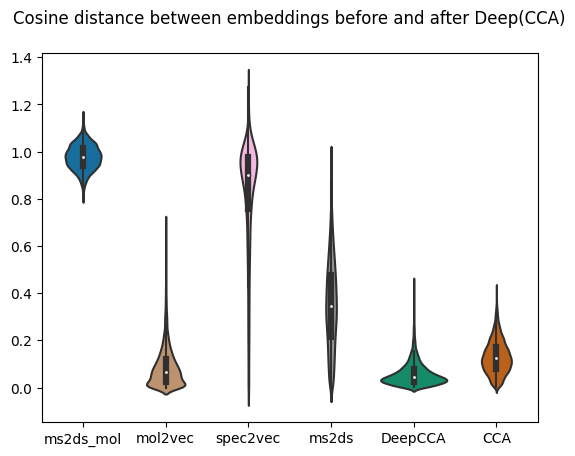

In [69]:
palette = [sns.color_palette("colorblind")[0],
           sns.color_palette("colorblind")[5],
           sns.color_palette("colorblind")[6],
           sns.color_palette("colorblind")[7],
           sns.color_palette("colorblind")[2], #SDL
           sns.color_palette("colorblind")[3], #CCA
          
          ] #random
sns.violinplot(embed_dist,estimator=np.mean, palette=palette)
plt.title(label='Cosine distance between embeddings before and after Deep(CCA)\n')
plt.show()

### Compare the embeddings cosine distance before and after DeepCCA was applied using only high scoring queries

In [23]:
test_df['sdl_tanis'] = sdl_tanis
test_df['cca_tanis'] = cca_tanis


# use filter at the predict() function instead

# sdl_high_test_df = test_df[test_df['sdl_tanis'] >= 0.8]
# cca_high_test_df = test_df[test_df['cca_tanis'] >= 0.8]

In [39]:
#spec2vec vs spec2vec
ms2ds_vs_mol2vec_before_sdl = embedding_similarity(hits_sdl, test_df,train_df)
spec2vec_vs_spec2vec_before_sdl = embedding_similarity(hits_sdl, 
                                                     test_df,
                                                     train_df,
                                                    method='spec2vec_vs_spec2vec')
#ms2ds vs ms2ds
ms2ds_vs_ms2dsc_before_sdl = embedding_similarity(hits_sdl, 
                                                     test_df,
                                                     train_df,
                                                    method='ms2ds_vs_ms2ds')
mol2vec_vs_mol2vec_before_sdl = embedding_similarity(hits_sdl, 
                                                     test_df,
                                                     train_df,
                                                    method='mol2vec_vs_mol2vec')

In [37]:
len(ms2ds_vs_mol2vec_before_sdl)

1712

In [34]:
cosine_after_sdl = []
for query_index, subject_index in hits_sdl.items():
    #print(subject_index[0][1])
    if subject_index[0][1] < 0.8:
        continue
    cos = sdl_cos[query_index][subject_index[0][0]]
    cosine_after_sdl.append(cos)
    #break
    
len(cosine_after_sdl) 

1712

In [40]:
high_embed_dist = pd.DataFrame({'ms2ds_mol': ms2ds_vs_mol2vec_before_sdl,
                           'mol2vec':mol2vec_vs_mol2vec_before_sdl,
                           'spec2vec':spec2vec_vs_spec2vec_before_sdl,
                           'ms2ds':ms2ds_vs_ms2dsc_before_sdl,
                          'DeepCCA':cosine_after_sdl,
                           #'CCA':cosine_after_cca,
                          })

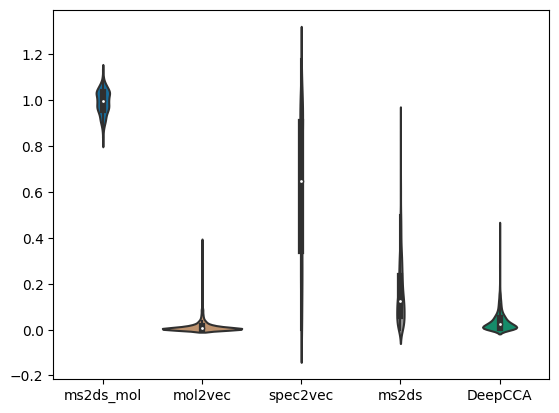

In [42]:
palette = [sns.color_palette("colorblind")[0],
           sns.color_palette("colorblind")[5],
           sns.color_palette("colorblind")[6],
           sns.color_palette("colorblind")[7],
           sns.color_palette("colorblind")[2], #SDL
           #sns.color_palette("colorblind")[3], #CCA
          
          ] #random
sns.violinplot(high_embed_dist,estimator=np.mean, palette=palette)
#plt.title(label='Cosine distance between embeddings before and after Deep(CCA)\n')
plt.show()

## 5. Compare Distance metrics (cosine vs euclidean vs correlation)

##### Step 5.1: Compute distances and Tanis

In [ ]:
# %%time
# #testing cca and sdl768 15 dims
# metrics = ['euc', 'corr', 'cos']
# # dists = []
# # hits = []
# # tanis = []

# dims = 15

# paths_distances = ['./sdl_768_15_dims/sdl_768_15_dims_euc_test_df',
#                    './sdl_768_15_dims_corr_test_df',
#                   './sdl_768_15_dims_cos_test_df'] # to write as generate

# paths_tanis = ['./sdl_768_15_dims/sdl_768_15_dims_euc_tanis_test_df',
#                    './sdl_768_15_dims/sdl_768_15_dims_corr_tanis_test_df',
#                   './sdl_768_15_dims/sdl_768_15_dims_cos_tanis_test_df'] # to write as generate

# paths_hits = ['./sdl_768_15_dims/sdl_768_15_dims_euc_hits_test_df',
#                    './sdl_768_15_dims/sdl_768_15_dims_corr_hits_test_df',
#                   './sdl_768_15_dims/sdl_768_15_dims_cos_hits_test_df'] # to write as generate

# for i, metric in enumerate(metrics):
#     dist = predict(subject_df=train_df,\
#                         query_df=test_df,dims=dims,\
#                         method='sdl_768', metric=metric)
    
#     tan, hit = get_tanimotos(dist,subject_df=train_df,\
#                                 query_df=test_df,\
#                                     metric=metric)
#     #dists.append(dist)
#     #hits.append(hit)
#     #tanis.append(tan)
#     Files(paths_distances[i]).write_to_file(dist)
#     Files(paths_tanis[i]).write_to_file(tan)
#     Files(paths_hits[i]).write_to_file(hits)
#     print(f'{metrics[i]} COMPLETE')
    

    
    

##### Step 5.2: load the computed tanis for each distance metric 

In [15]:

tanis = []
paths_tanis = ['./sdl_768_15_dims/sdl_768_15_dims_euc_tanis_test_df',
                   './sdl_768_15_dims/sdl_768_15_dims_corr_tanis_test_df',
                  './sdl_768_15_dims/sdl_768_15_dims_cos_tanis_test_df']

for i in paths_tanis:
    #print(i)
    tani = Files(i).load_pickle()
    tanis.append(tani)
len(tanis[0])

8290

##### Step 5.3: plot the distribution of Tanimoto from each distance metric

/tmp/ipykernel_11008/2699313026.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(x=dist,color = palette[i],shade=False)
/tmp/ipykernel_11008/2699313026.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(x=dist,color = palette[i],shade=False)
/tmp/ipykernel_11008/2699313026.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(x=dist,color = palette[i],shade=False)


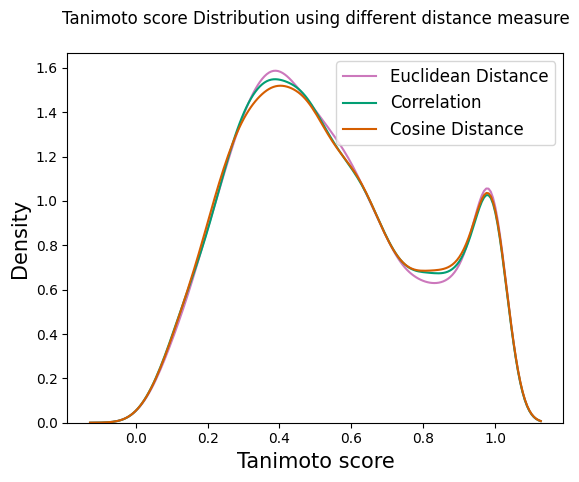

In [19]:
#plot the distribution of the three top tanimotos from euc, corr, and cos

palette = [sns.color_palette("colorblind")[4], #euc
           sns.color_palette("colorblind")[2], #corr
           sns.color_palette("colorblind")[3], #cos
          #sns.color_palette("colorblind")[9] #random
          ] 

for i, dist in enumerate(tanis):
    ax=sns.kdeplot(x=dist,color = palette[i],shade=False)
plt.legend(labels=['Euclidean Distance',
                   'Correlation',
                   'Cosine Distance',
                   #'Random'
                  ], loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution using different distance measure\n', fontsize=12)
# plt.savefig(f'../plots/max3_tanimoto_euc_distribution.png',\
#            transparent=False,bbox_inches = 'tight')
plt.show()

In [21]:
print('Euc mean:', np.mean(tanis[0]),'Corr mean:', np.mean(tanis[1]),'Cos mean:', np.mean(tanis[2]))

Euc mean: 0.5383141616405307 Corr mean: 0.5379931604342583 Cos mean: 0.5395592521109771


In [22]:
df = pd.DataFrame({'Euclidean': tanis[0],
                   'Correlation':tanis[1],
                   'Cosine': tanis[2]
    
})

In [ ]:
palette = [sns.color_palette("colorblind")[4], #euc
           sns.color_palette("colorblind")[2], #corr
           sns.color_palette("colorblind")[3], #cos
          #sns.color_palette("colorblind")[9] #random
          ]
plt.title(label='Tanimoto score Distribution using different distance measure\n', fontsize=12)
sns.violinplot(df, palette=palette)
plt.xlabel('Distance metric')
plt.ylabel('Tanimoto score')

plt.show()

In [ ]:
## THE SECTION BELOW NEEDS STRUCTURING !!!!

In [33]:
 %%time
test_sdl_corr_dim_10 = predict(subject_df=train_df,\
                        query_df=test_df,dims=dims,\
                        method='sdl', metric='corr')

#tanimotos, and the top hit  using corr  
test_sdl_corr_dim_10_tanimotos, hits_sdl_corr_dim_10 = get_tanimotos(test_sdl_corr_dim_10, \
                                       subject_df=train_df,\
                                        query_df=test_df,\
                                        metric='corr')


[02:43:24] WARNING: not removing hydrogen atom without neighbors
[02:44:16] WARNING: not removing hydrogen atom without neighbors
[02:44:22] WARNING: not removing hydrogen atom without neighbors
[02:45:43] WARNING: not removing hydrogen atom without neighbors
[02:45:52] WARNING: not removing hydrogen atom without neighbors
[02:46:33] WARNING: not removing hydrogen atom without neighbors
[02:46:39] WARNING: not removing hydrogen atom without neighbors
[02:46:41] WARNING: not removing hydrogen atom without neighbors
[02:47:13] WARNING: not removing hydrogen atom without neighbors
[02:47:36] WARNING: not removing hydrogen atom without neighbors
[02:47:49] WARNING: not removing hydrogen atom without neighbors
[02:48:28] WARNING: not removing hydrogen atom without neighbors
[02:48:32] WARNING: not removing hydrogen atom without neighbors
[02:49:04] WARNING: not removing hydrogen atom without neighbors
[02:49:59] WARNING: not removing hydrogen atom without neighbors
[02:50:36] WARNING: not r

Wall time: 2h 51min 20s


In [ ]:

%%time
test_sdl_cos_dim_10 = predict(subject_df=train_df,\
                        query_df=test_df,dims=dims,\
                        method='sdl', metric='cos')
#tanimotos, and the top hit  using cos  
test_sdl_cos_dim_10_tanimotos, hits_sdl_cos_dim_10 = get_tanimotos(test_sdl_cos_dim_10, \
                                       subject_df=train_df,\
                                        query_df=test_df,\
                                        metric='cos')


In [35]:
#random tanimotos
random_tanimotos = random_tanimoto(test_sdl_cos_dim_10, \
                                       subject_df=train_df,\
                                       query_df=test_df)


In [13]:
paths = ['./max3_sdl_tanimoto_dims_10.pickle', 
         './max3_cca_tanimoto_dims_10.pickle',
        ]
         #'./max3_sdl_cos_tanimoto_dims_10_20_nn.pickle']

sdl_dims10_tanis = Files(paths[0]).load_pickle()
cca_dims10_tanis = Files(paths[1]).load_pickle()
len(cca_dims10_tanis)


path_cos = './max3_cca_euc_dims_10.pickle'

sdl_cos_10 = Files(path_cos).load_pickle()

paths = ['./max3_sdl_dims_10_best_train_df_with_z.pickle',
        './max3_sdl_dims_10_test_df_with_z.pickle']
train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()

In [14]:
#random tanimotos
random_tanimotos = random_tanimoto(sdl_cos_10,\
                                       subject_df=train_df,\
                                       query_df=test_df)
len(sdl_cos_10)

8290

In [15]:
len(random_tanimotos)

8290

In [44]:
df = pd.DataFrame({'DeepCCA_Tanimoto':[x for x in sdl_dims10_tanis],
                  'CCA_Tanimoto': [x for x in cca_dims10_tanis],
                   'Random_Tanimoto': [x for x in random_tanimotos]
                  })

In [45]:
df.head()

,DeepCCA_Tanimoto,CCA_Tanimoto,Random_Tanimoto
0,0.3717,0.3434,0.0674
1,0.5107,0.4432,0.2623
2,0.8632,0.8521,0.3890
3,0.7112,0.6175,0.2364
4,0.5995,0.5764,0.3471


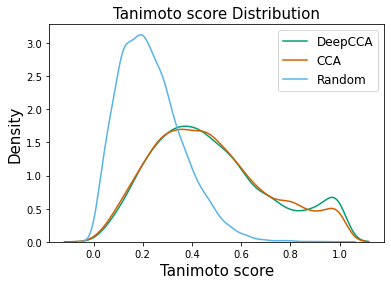

In [16]:
#plot the distribution of the three top tanimotos from the three metrics

palette = [#sns.color_palette("colorblind")[4], #DCCA
           sns.color_palette("colorblind")[2], #SDL
           sns.color_palette("colorblind")[3], #CCA
          sns.color_palette("colorblind")[9]] #random
dist_list = [sdl_dims10_tanis,
             cca_dims10_tanis,
            random_tanimotos]
for i, dist in enumerate(dist_list):
    ax=sns.kdeplot(x=dist,color = palette[i],shade=False)
plt.legend(labels=[#'DCCA',
                   'DeepCCA',
                   'CCA',
                   'Random'
                  ], loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution', fontsize=15)
# plt.savefig(f'../plots/max3_tanimoto_euc_distribution.png',\
#            transparent=False,bbox_inches = 'tight')
plt.show()

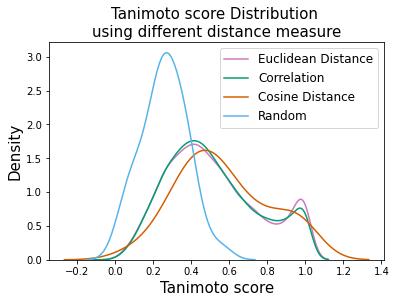

In [44]:
#plot the distribution of the three top tanimotos from the three metrics

palette = [sns.color_palette("colorblind")[4], #euc
           sns.color_palette("colorblind")[2], #corr
           sns.color_palette("colorblind")[3], #cos
          sns.color_palette("colorblind")[9]] #random
dist_list = [test_sdl_euc_dim_10_tanimotos,
             test_sdl_corr_dim_10_tanimotos,
             test_sdl_cos_dim_10_tanimotos,
            random_tanimotos]
for i, dist in enumerate(dist_list):
    ax=sns.kdeplot(x=dist,color = palette[i],shade=False)
plt.legend(labels=['Euclidean Distance',
                   'Correlation',
                   'Cosine Distance',
                   'Random'
                  ], loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution \nusing different distance measure', fontsize=15)
# plt.savefig(f'../plots/max3_tanimoto_euc_distribution.png',\
#            transparent=False,bbox_inches = 'tight')
plt.show()

In [37]:
dists= [test_sdl_euc_dim_10,test_sdl_corr_dim_10,test_sdl_cos_dim_10]
hits = [hits_sdl_euc_dim_10,hits_sdl_corr_dim_10,hits_sdl_cos_dim_10]
tanis = [test_sdl_euc_dim_10_tanimotos,test_sdl_corr_dim_10_tanimotos,test_sdl_cos_dim_10_tanimotos]




In [43]:
len(dists[0])

8290

In [105]:
# paths = ['./max3_sdl_euc_dims_10.pickle', './max3_sdl_corr_dims_10.pickle','./max3_sdl_cos_dims_10.pickle']

# for euc, path in zip(dists,paths):
#     Files(path).write_to_file(euc)

In [ ]:
# paths = ['./max3_sdl_euc_hits_dims_10_20_nn.pickle', './max3_sdl_hits_corr_dims_10_20_nn.pickle','./max3_sdl_hits_cos_dims_10_20_nn.pickle']

# for hit, path in zip(hits,paths):
#     Files(path).write_to_file(hit)

In [40]:
# paths = ['./max3_sdl_euc_tanimoto_dims_10_20_nn.pickle', './max3_sdl_corr_tanimoto_dims_10_20_nn.pickle','./max3_sdl_cos_tanimoto_dims_10_20_nn.pickle']

# for tan, path in zip(tanis,paths):
#     Files(path).write_to_file(tan)

In [67]:
%%time

dims = 10
#n=50
nn=10
metric = 'euc'
#predict sdl euc
test_sdl_euc = predict(subject_df=Models.train_df,\
                        query_df=Models.test_df,dims=dims,\
                        method='sdl', metric=metric)
#tanimotos, and the top hit    
test_sdl_euc_tanimotos, hits_sdl = get_tanimotos(test_sdl_euc, \
                                       subject_df=Models.train_df,\
                                        query_df=Models.test_df,\
                                        metric=metric)
# dcca
test_dcca_euc = predict(subject_df=Models.train_df,\
                        query_df=Models.test_df,dims=dims,\
                        method='dcca', metric=metric)
#tanimotos, and the top hit    
test_dcca_euc_tanimotos, hits_dcca = get_tanimotos(test_dcca_euc, \
                                       subject_df=Models.train_df,\
                                        query_df=Models.test_df,\
                                        metric=metric)

#cca
test_cca_euc = predict(subject_df=Models.train_df,\
                       query_df=Models.test_df,dims=dims,\
                       method='cca',metric=metric)
#tanimotos, and the top hit 
test_cca_euc_tanimotos,hits_cca = get_tanimotos(test_cca_euc, \
                       subject_df=Models.train_df,\
                       query_df=Models.test_df, \
                                       metric=metric)

#random tanimotos
random_tanimotos = random_tanimoto(test_cca_euc, \
                                       subject_df=Models.train_df,\
                                       query_df=Models.test_df)



[00:14:20] WARNING: not removing hydrogen atom without neighbors
[00:14:21] WARNING: not removing hydrogen atom without neighbors
[00:15:00] WARNING: not removing hydrogen atom without neighbors
[00:15:22] WARNING: not removing hydrogen atom without neighbors
[00:15:25] WARNING: not removing hydrogen atom without neighbors
[00:16:36] WARNING: not removing hydrogen atom without neighbors
[00:17:02] WARNING: not removing hydrogen atom without neighbors
[00:17:58] WARNING: not removing hydrogen atom without neighbors
[00:43:48] WARNING: not removing hydrogen atom without neighbors


Wall time: 1h 29min 22s


In [150]:
%%time
#tanimotos, and the top hit    
test_sdl_euc_tanimotos, hits_sdl_20_nn = get_tanimotos(test_sdl_euc, \
                                       subject_df=Models.train_df,\
                                        query_df=Models.test_df,\
                                        metric=metric,nn=20)

[11:05:08] WARNING: not removing hydrogen atom without neighbors
[11:05:17] WARNING: not removing hydrogen atom without neighbors
[11:07:04] WARNING: not removing hydrogen atom without neighbors
[11:08:00] WARNING: not removing hydrogen atom without neighbors
[11:08:02] WARNING: not removing hydrogen atom without neighbors
[11:08:42] WARNING: not removing hydrogen atom without neighbors
[11:09:28] WARNING: not removing hydrogen atom without neighbors
[11:10:16] WARNING: not removing hydrogen atom without neighbors
[11:10:22] WARNING: not removing hydrogen atom without neighbors
[11:12:56] WARNING: not removing hydrogen atom without neighbors
[11:13:52] WARNING: not removing hydrogen atom without neighbors
[11:15:57] WARNING: not removing hydrogen atom without neighbors
[11:18:35] WARNING: not removing hydrogen atom without neighbors


Wall time: 14min 30s


In [154]:
%%time
#tanimotos, and the top hit 
test_cca_euc_tanimotos,hits_cca_20_nn = get_tanimotos(test_cca_euc, \
                       subject_df=Models.train_df,\
                       query_df=Models.test_df, \
                                       metric=metric, nn=20)

Wall time: 12min 51s


In [156]:
%%time
#tanimotos, and the top hit    
test_dcca_euc_tanimotos, hits_dcca_20_nn = get_tanimotos(test_dcca_euc, \
                                       subject_df=Models.train_df,\
                                        query_df=Models.test_df,\
                                        metric=metric,nn=20)

[11:58:57] WARNING: not removing hydrogen atom without neighbors


Wall time: 12min 56s


In [ ]:
eucs = [test_sdl_euc,test_dcca_euc,test_cca_euc]
hits = [hits_sdl_20_nn,hits_dcca_20_nn,hits_cca_20_nn]
tanis = [test_sdl_euc_tanimotos,test_dcca_euc_tanimotos,test_cca_euc_tanimotos]




In [25]:
tani = Files('./sdl_768_15_dims/sdl_768_15_dims_cos_tanis_test_df').load_pickle()

0.5395592521109771

In [69]:
paths = ['./max3_sdl_euc_dims_10.pickle', './max3_dcca_euc_dims_10.pickle','./max3_cca_euc_dims_10.pickle']

for euc, path in zip(eucs,paths):
    Files(path).write_to_file(euc)

In [ ]:
paths = ['./max3_sdl_hits_dims_10_20_nn.pickle', './max3_dcca_hits_dims_10_20_nn.pickle','./max3_cca_hits_dims_10_20_nn.pickle']

for hit, path in zip(hits,paths):
    Files(path).write_to_file(hit)

In [ ]:
paths = ['./max3_sdl_tanimoto_dims_10_20_nn.pickle', './max3_dcca_tanimoto_dims_10_20_nn.pickle','./max3_cca_tanimoto_dims_10_20_nn.pickle']

for tan, path in zip(tanis,paths):
    Files(path).write_to_file(tan)

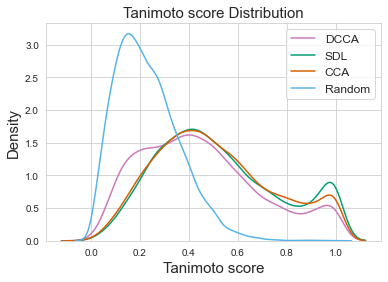

In [157]:
#plot the distribution of the three top tanimotos from the three metrics

palette = [sns.color_palette("colorblind")[4], #DCCA
           sns.color_palette("colorblind")[2], #SDL
           sns.color_palette("colorblind")[3], #CCA
          sns.color_palette("colorblind")[9]] #random
dist_list = [test_dcca_euc_tanimotos,
             test_sdl_euc_tanimotos,
             test_cca_euc_tanimotos,
            random_tanimotos]
for i, dist in enumerate(dist_list):
    ax=sns.kdeplot(x=dist,color = palette[i],shade=False)
plt.legend(labels=['DCCA',
                   'SDL',
                   'CCA',
                   'Random'
                  ], loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution', fontsize=15)
# plt.savefig(f'../plots/max3_tanimoto_euc_distribution.png',\
#            transparent=False,bbox_inches = 'tight')
plt.show()

#### Draw Random predicted molecule

In [4]:
#os.listdir()

In [20]:
# load hits this was with nn=100
paths = ['./max3_sdl_hits.pickle','./max3_dcca_hits.pickle','./max3_cca_hits.pickle']
hits_sdl = Files(paths[0]).load_pickle()
hits_dcca = Files(paths[1]).load_pickle()
hits_cca = Files(paths[2]).load_pickle()

In [22]:
#load dfs
paths = ['./max3_train_df_with_z.pickle',
        './max3_test_df_with_z.pickle',
        './max3_val_df_with_z.pickle']

train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()
val_df = Files(paths[2]).load_pickle()


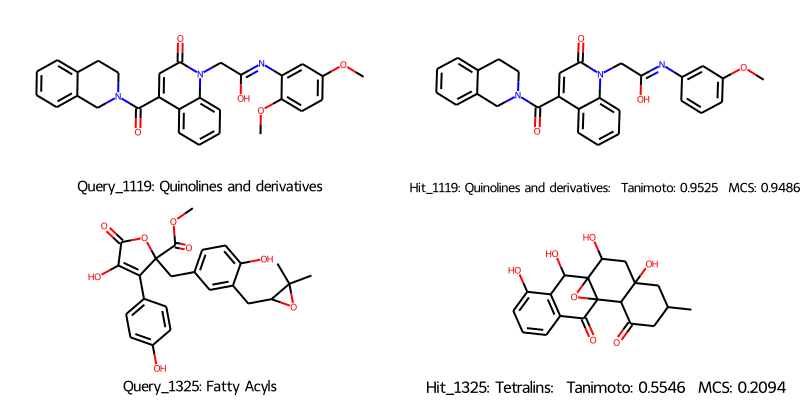

In [129]:
#randomly pick a query
keys = random.choices(list(hits_sdl.keys()),k=2)
subset_hits = {key: hits_sdl[key] for key in keys}

#draw the random queries plus their hits
sdl_random_mols, sdl_random_legends = pick_hit_mols(subset_hits,
                                                    train_df,test_df)

mols = []
for query, hit in zip(sdl_random_mols[0], sdl_random_mols[1]):
    mols.append(query)
    mols.append(hit)
legends = []
for query_label, hit_label in zip(sdl_random_legends[0], 
                                  sdl_random_legends[1]):
    legends.append(query_label)
    legends.append(hit_label)
    
len(sdl_random_mols[0])
Draw.MolsToGridImage(mols,
                        molsPerRow=2, 
                        legends = legends,
                        subImgSize=(400,200),
                                returnPNG=True)


### Test how the model performs with classes appearing less than 2 times

In [12]:
# select classes appearing < 2 times in the train dataset
train_rare_classes = train_df.groupby('cf_class').filter(lambda x : 2 >= len(x))
train_rare_classes.shape

(79, 12)

In [13]:
# select classes appearing < 2 times in the test dataset
test_rare_classes = test_df.\
loc[test_df['cf_class'].isin([x for x in \
                                         train_rare_classes['cf_class']])]

test_rare_classes.shape

(33, 12)

In [14]:
test_rare_classes = random.choices([x for x in test_rare_classes['cf_class']],k=10)

In [11]:
# sdl rare mols
sdl_rare_mols, sdl_rare_legends, sdl_rare_tanis = pick_hit_mols(hits_sdl,train_df,test_df,
          group=test_rare_classes,
                              return_tanimoto=True,filterby='cf_class')
Draw.MolsToGridImage(sdl_rare_mols,
                        molsPerRow=2, 
                        legends = sdl_rare_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

NameError: name 'test_rare_classes' is not defined

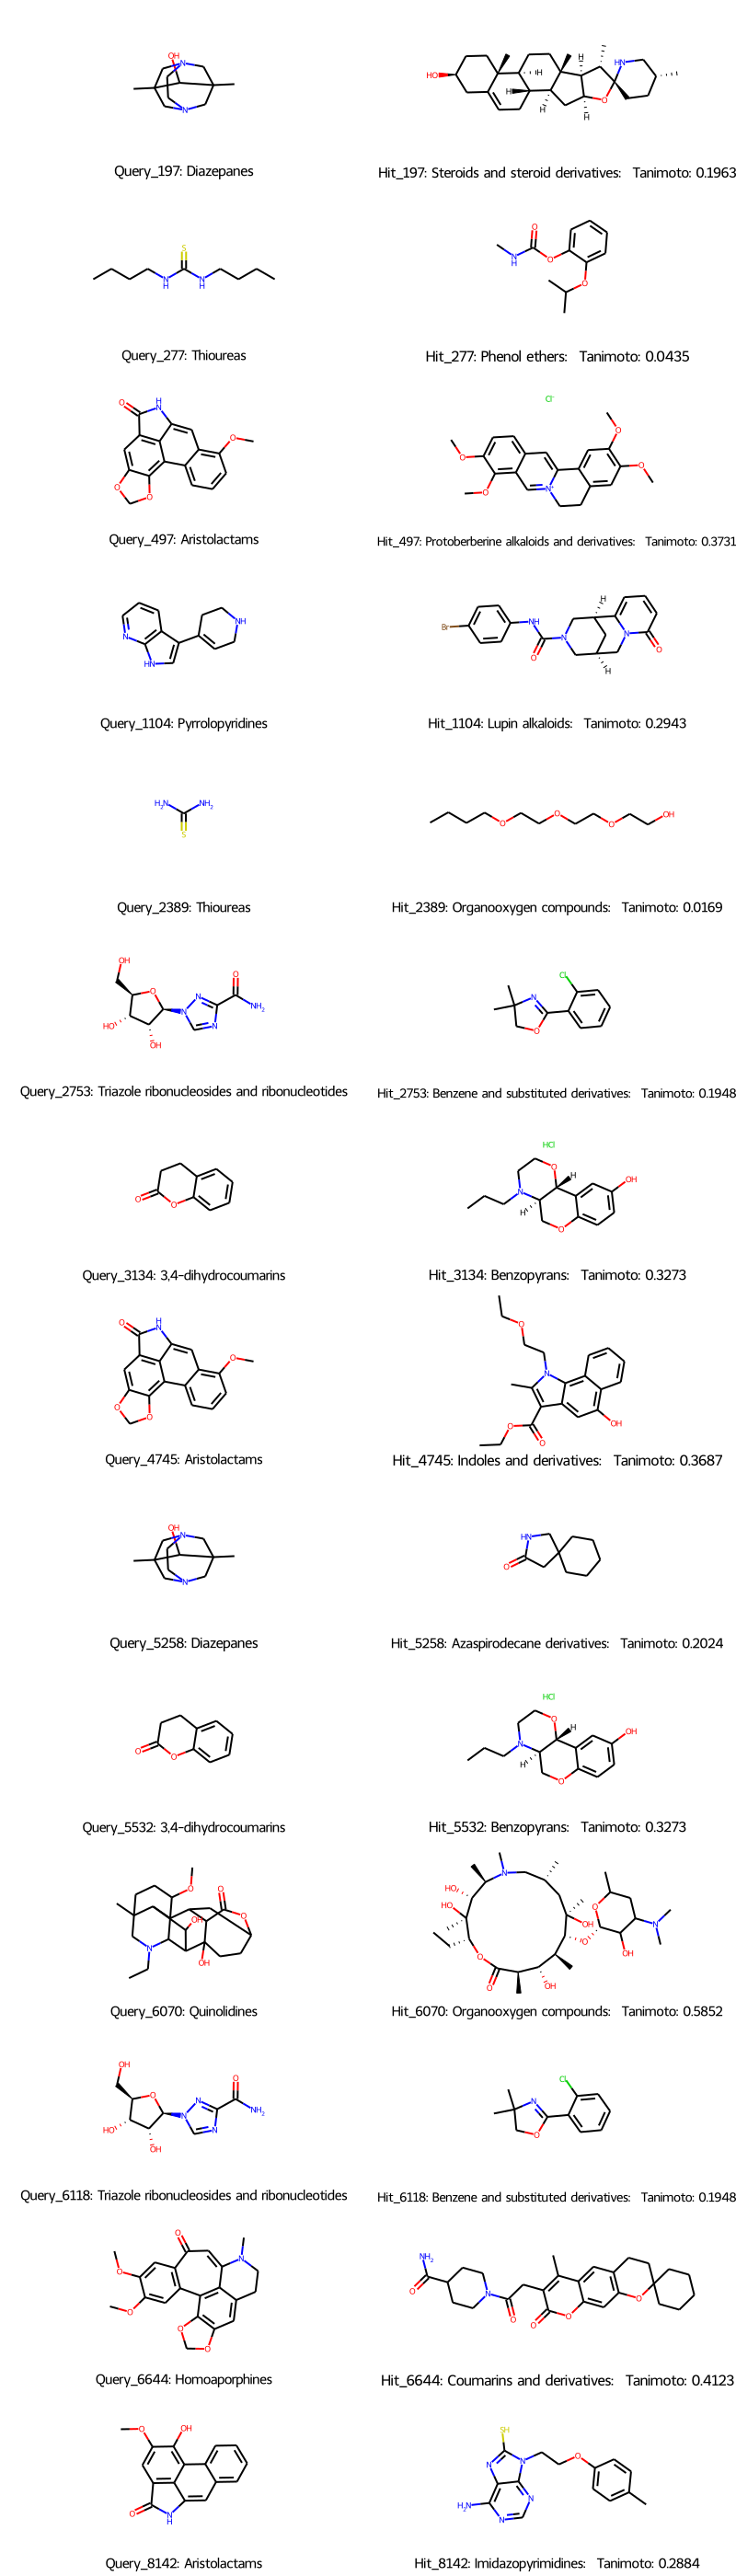

In [126]:
# cca rare mols
cca_rare_mols, cca_rare_legends, cca_rare_tanis = pick_hit_mols(hits_cca,train_df,test_df,
          group=test_rare_classes,filterby='cf_class',
                              return_tanimoto=True)
Draw.MolsToGridImage(cca_rare_mols,
                        molsPerRow=2, 
                        legends = cca_rare_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

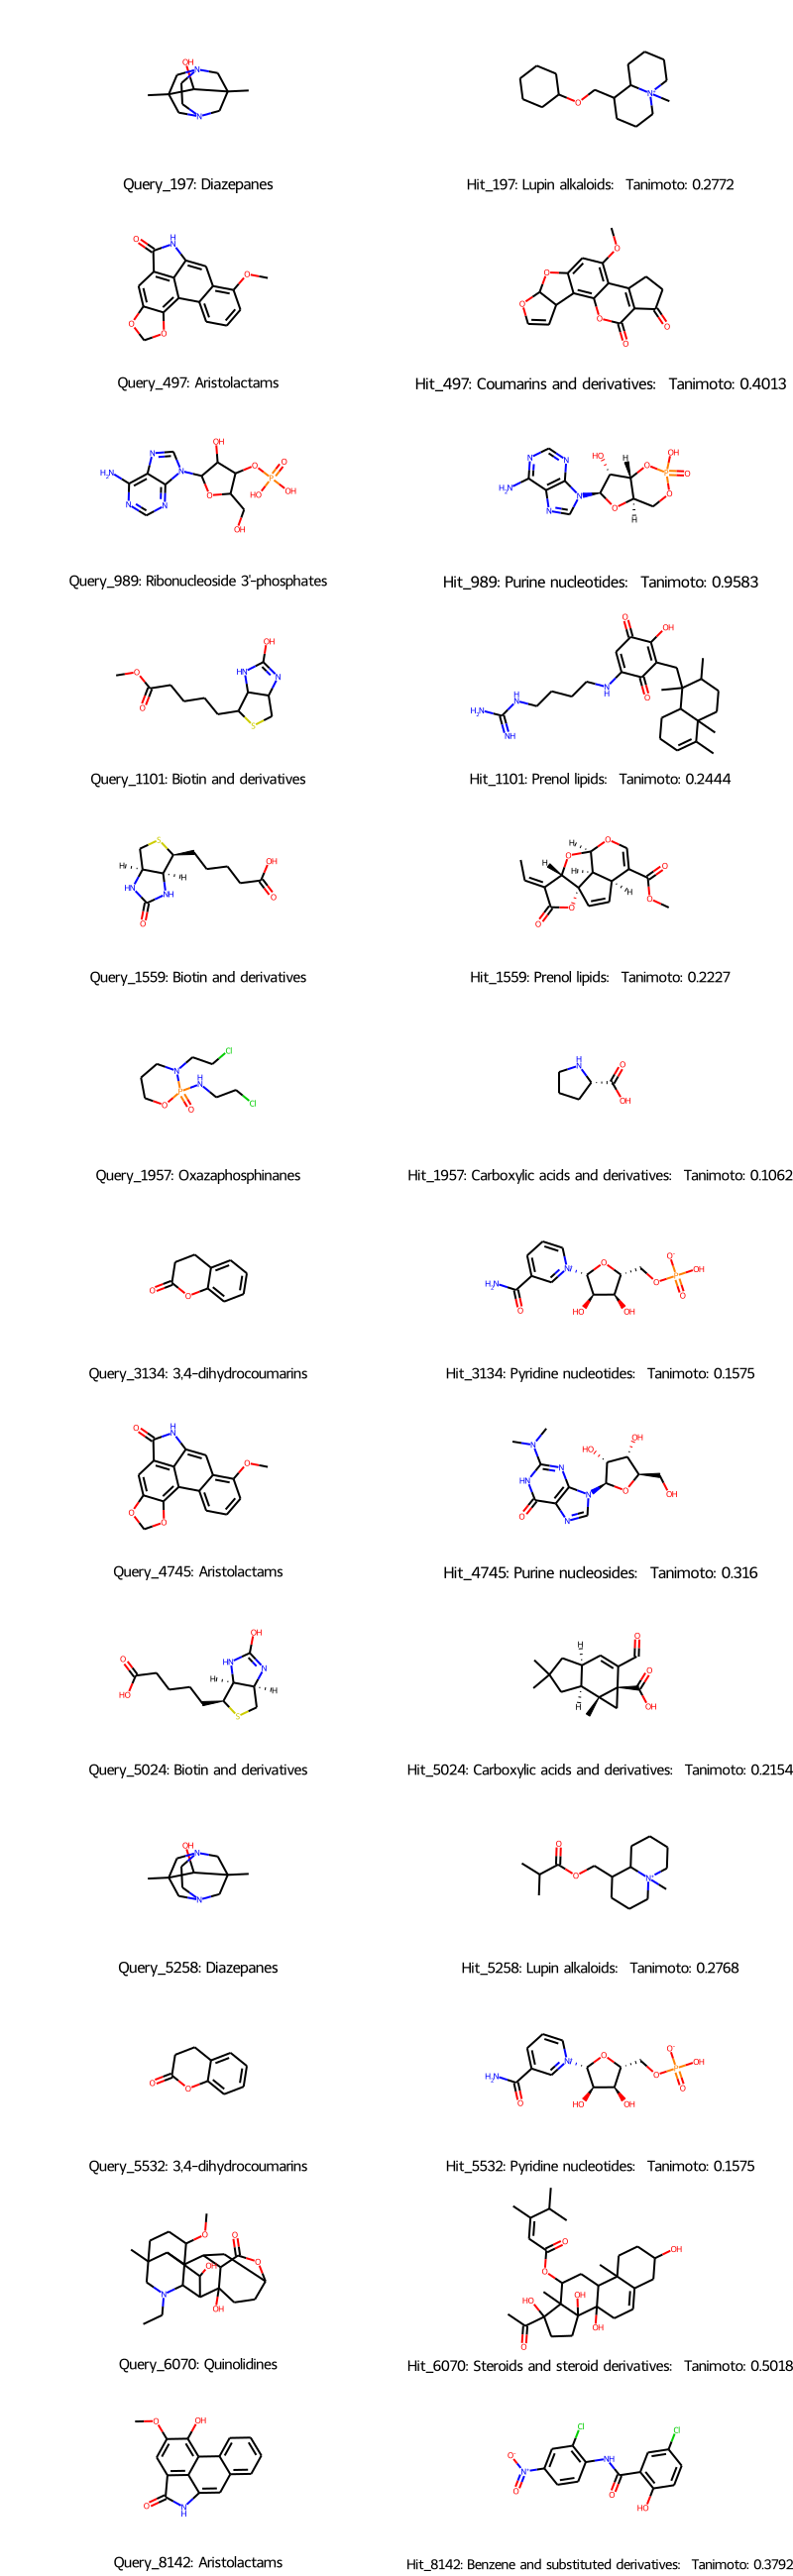

In [185]:
# dcca rare mols
dcca_rare_mols, dcca_rare_legends, dcca_rare_tanis = pick_hit_mols(hits_dcca,train_df,test_df,
          group=test_rare_classes,filterby='cf_class',
                              return_tanimoto=True)
Draw.MolsToGridImage(dcca_rare_mols,
                        molsPerRow=2, 
                        legends = dcca_rare_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

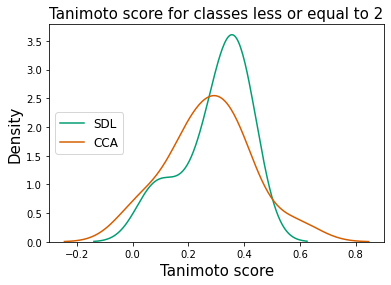

In [128]:
#justice for the color blind :)
palette = [sns.color_palette("colorblind")[4],\
           sns.color_palette("colorblind")[2],\
           sns.color_palette("colorblind")[3]]
tanis = [sdl_rare_tanis,cca_rare_tanis]
legends = ['SDL', 'CCA']
xlab, ylab = 'Tanimoto score', 'Density'
title = 'Tanimoto score for classes less or equal to 2'
fig_path = './rare_class_tanis.png'

plot_distribution(tanis, title,
                      legends=legends,xlab=xlab,
                    ylab=ylab,
                  palette = palette[1:3],
                     fig_path=fig_path,
                     savefig=True)

#### Investigate if the models will always return true hits if it is in the subject dataset(database)

In [19]:
# select inchikey14 occuring both in test(query) and train(subject) 
common_inchikeys =train_df.groupby('inchikey14').filter(lambda x : len(x)>=2)
common_inchikeys.shape

(20773, 12)

In [20]:
common_chi_list = [x for x in common_inchikeys['inchikey14']]

In [21]:
test_common_ichi= test_df.\
loc[test_df['inchikey14'].isin(common_chi_list)]
test_common_ichi.shape

test_common_list = [x for x in test_common_ichi['inchikey14']]#,k=10)# sample a few to draw structures

In [31]:
%%time
# sdl common mols (not common anymore if you hash out group=)
sdl_mols, sdl_mol_legends, sdl_mol_tanis = pick_hit_mols(hits_sdl,train_df,test_df,
          #group=test_common_list,
                              return_tanimoto=True)
# Draw.MolsToGridImage(sdl_common_mols,
#                         molsPerRow=2, 
#                         legends = sdl_common_legends,
#                         subImgSize=(400,200),
#                                 returnPNG=True)

Wall time: 8.18 s


In [38]:
len(sdl_mol_tanis)

8290

In [133]:
# cca common mols
cca_common_mols, cca_common_legends, cca_common_tanis = pick_hit_mols(hits_cca,train_df,test_df,
          #group=test_common_list,
                              return_tanimoto=True)
# Draw.MolsToGridImage(cca_common_mols,
#                         molsPerRow=2, 
#                         legends = cca_common_legends,
#                         subImgSize=(400,200),
#                                 returnPNG=True)

In [134]:
len(cca_common_tanis)

8290

In [122]:
# dcca common mols
dcca_common_mols, dcca_common_legends, dcca_common_tanis = pick_hit_mols(hits_dcca,Models.train_df,Models.test_df,
          #group=test_common_list,
                              return_tanimoto=True)
# Draw.MolsToGridImage(dcca_common_mols,
#                         molsPerRow=2, 
#                         legends = dcca_common_legends,
#                         subImgSize=(400,200),
#                                 returnPNG=True)

In [105]:
len(sdl_common_tanis)

2746

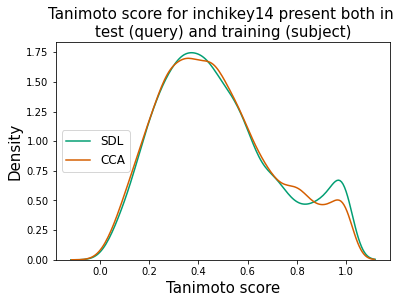

In [135]:
tanis = [#dcca_common_tanis,
         sdl_common_tanis,
         cca_common_tanis]
legends = [#'DCCA', 
           'SDL',
           'CCA']
xlab, ylab = 'Tanimoto score', 'Density'
title = 'Tanimoto score for inchikey14 present both in \ntest (query) and training (subject)'
fig_path = './common_class_tanis.png'

plot_distribution(tanis, title,
                      legends=legends,xlab=xlab,
                    ylab=ylab,
                      palette = palette[1:3],
                     fig_path=fig_path,
                     savefig=False)

In [28]:
#apply this to tanis
df = pd.DataFrame({'eucledian':[x for x in tanis_euc],
                  'correlation':[x for x in tanis_corr],
                  'cosine':[x for x in tanis_cos]
                 })

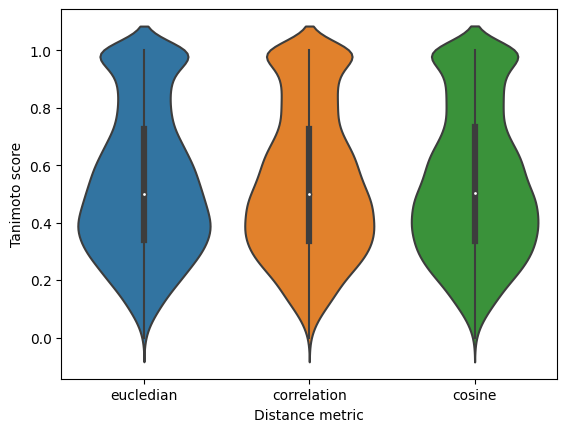

In [29]:
# violin plot

palette = sns.color_palette("bright")
#for i, tan in enumerate(tanis):
sns.violinplot(df)
#plt.legend(labels=metrics, loc='upper right', fontsize=12)
plt.xlabel('Distance metric')
plt.ylabel('Tanimoto score')
plt.show()

In [38]:
# group queries based on tanimoto scores with their top hit
def group_tanimotos(tanis):
    category = []
    for tani in tanis:
        if tani <= 0.5:
            category.append('Low (tanimoto=<0.5)')
        elif 0.5 < tani < 0.8:
            category.append('Medium (0.5<tanimoto<0.8)')
        elif tani >= 0.8:
            category.append('High (tanimoto>=0.8)')
        
    return category

In [45]:
#categories tanis
sdl_tanis_category = group_tanimotos(sdl_mol_tanis[0])
cca_tanis_category = group_tanimotos(cca_mol_tanis[0])

In [46]:
cca_tanis_category.count('High (tanimoto>=0.8)')

1587

In [47]:
sdl_tanis_category.count('High (tanimoto>=0.8)')

1712

In [48]:
# create a column in the df with category; also append the tanis to be sure they were well categorised
test_df['cca_category'] = cca_tanis_category
test_df['sdl_category'] = sdl_tanis_category

test_df['sdl_tanimoto'] = sdl_mol_tanis[0]
test_df['cca_tanimoto'] = cca_mol_tanis[0]
test_df.head()


# test_common_ichi['category'] = category
# test_common_ichi['tanimoto'] = sdl_common_tanis
# test_common_ichi.tail()
#no idea of pandas warnings; but if it works dont touch :)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,cca_z1,cca_z2,sdl_768_z1,sdl_768_z2,cca_category,sdl_category,sdl_tanimoto,cca_tanimoto
5625,COc1ccc(cc1OC)C(=O)NCc2ccc(OCCN(C)C)cc2,QQQIECGTIMUVDS-UHFFFAOYSA-N,QQQIECGTIMUVDS,spec_id5019,"[0.7660381606480904, -2.9954168988462215, -12....","[0.0, 13.000274658203125, 0.35151147842407227,...","[-0.45550603, -3.2559516, -3.0893652, 5.457150...",Benzene and substituted derivatives,"[0.05153173450592052, -0.6290144322197803, 0.3...","[-0.36705695389751064, -0.7741333930770977, 0....","[0.89759576, -0.44103494, 0.25500268, -0.23932...","[0.8142293, -0.8455215, 0.10232448, 0.03982669...",Low (tanimoto=<0.5),Low (tanimoto=<0.5),0.3434,0.4841
40023,COc1cc(OC)c2c(OC)c(-c3ccc4c(c3)OCO4)c(=O)oc2c1,PZYZNVLXKYMURF-UHFFFAOYSA-N,PZYZNVLXKYMURF,spec_id39710,"[4.160680518910307, -17.534900146210205, -20.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 63.7232666015625, 5....","[1.2124093, -3.7327924, -5.30343, 5.8895183, 0...",Isoflavonoids,"[-0.5501047970140038, 0.38237380310465097, 0.3...","[-0.4201982466068921, -0.10796739852068316, -0...","[-1.9857152, 0.01580453, 0.34879375, -0.063378...","[-2.6851432, 0.07175583, 0.100825734, -0.03386...",Medium (0.5<tanimoto<0.8),Medium (0.5<tanimoto<0.8),0.5405,0.5708
32710,O=C2C(O)=C(OC=3C=C(OC1OC(CO)C(O)C(O)C1(O))C(OC...,AFCDXKGLUDDXCK-UHFFFAOYSA-N,AFCDXKGLUDDXCK,spec_id31385,"[4.156373062713153, 2.6467714749778737, -9.709...","[25.13886260986328, 20.056901931762695, 0.0, 0...","[3.884097, -4.328525, -8.565995, 3.9552908, 1....",Flavonoids,"[-0.06586338409618886, 0.942967588380739, -1.8...","[-0.20775599360011476, 0.7636143826119569, -1....","[-2.7716846, 0.6372789, -0.17924559, 0.3081886...","[-2.6338186, 0.40164477, -0.020541228, 0.06371...",High (tanimoto>=0.8),High (tanimoto>=0.8),0.8622,0.9095
14421,C1OC2=C(O1)C=C(C=C2)C3=COC4=C(C3=O)C=CC(=C4)O,KNJNBKINYHZUGC-UHFFFAOYSA-N,KNJNBKINYHZUGC,spec_id12744,"[-2.8919476279177254, 7.136436073237354, -11.3...","[0.0, 10.869701385498047, 0.0, 0.9871315956115...","[1.584554, -2.3259673, -3.662932, 4.6133733, -...",Isoflavonoids,"[-0.28901973200670295, -0.3118134545305635, -0...","[-0.4108115967805857, -0.1128494291565022, -0....","[-1.6638566, -0.14555125, -0.07093884, 0.05283...","[-2.1585412, -0.0425117, -0.9576257, 0.1188292...",Medium (0.5<tanimoto<0.8),High (tanimoto>=0.8),0.8596,0.6591
24733,O=C(OC1C(OC(OCCC2=CC=C(O)C(O)=C2)C(OC(=O)C)C1O...,ALERZNQPBWWLMW-UHFFFAOYSA-N,ALERZNQPBWWLMW,spec_id23060,"[-4.41229641164563, -6.063199486461368, 5.2722...","[2.8529367446899414, 9.61679458618164, 15.8730...","[1.791454, -10.160973, -14.062275, 4.4526644, ...",Cinnamic acids and derivatives,"[-0.4426021969600858, 1.809169159153108, -1.36...","[-0.045717320727094835, 0.8496795834228216, -1...","[0.23103917, 1.7803116, 0.6962889, -0.04533320...","[1.5970452, 0.87056667, 0.012284648, 0.0887110...",Low (tanimoto=<0.5),Low (tanimoto=<0.5),0.4717,0.4704


In [49]:
x_sdl = np.array([i for i in test_df['sdl_768_z1']])

y_sdl = np.array([i for i in test_df['sdl_768_z2']])

x_cca = np.array([i for i in test_df['cca_z1']])

y_cca = np.array([i for i in test_df['cca_z2']])

In [50]:
tsne = TSNE(n_components=2, 
            verbose=0, 
            perplexity=10, # assuming these is related to neighbours
            n_iter=1000,
           init = 'pca',
           learning_rate = 'auto'
           )

x_sdl_transformed = tsne.fit_transform(x_sdl)
y_sdl_transformed = tsne.fit_transform(y_sdl)

x_cca_transformed = tsne.fit_transform(x_cca)
y_cca_transformed = tsne.fit_transform(y_cca)


/lustre/BIF/nobackup/lmeli001/miniconda3/envs/cca/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/lustre/BIF/nobackup/lmeli001/miniconda3/envs/cca/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/lustre/BIF/nobackup/lmeli001/miniconda3/envs/cca/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/lustre/BIF/nobackup/lmeli001/miniconda3/envs/cca/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in

No handles with labels found to put in legend.


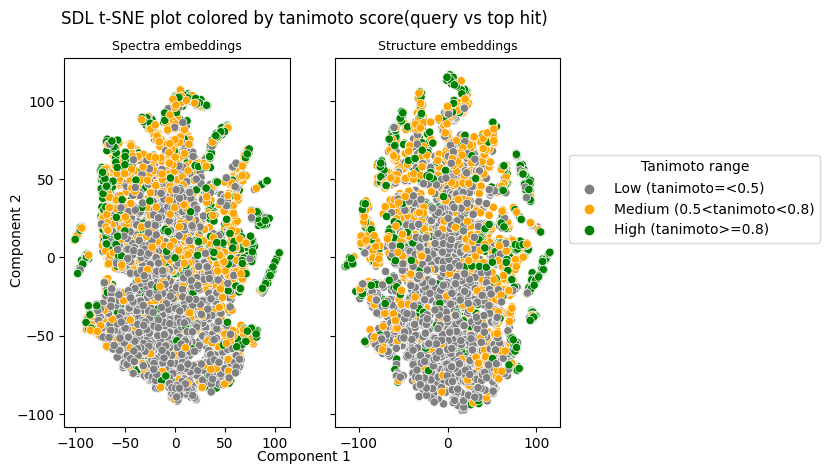

In [57]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.scatterplot(x=x_sdl_transformed[:,0],
           y=x_sdl_transformed[:,1], hue = category, 
                palette = ['grey', 'orange','green'],
                ax=ax1, legend=False)


sns.scatterplot(x=y_sdl_transformed[:,0],
           y=y_sdl_transformed[:,1], hue = category,
                palette = ['grey', 'orange','green'],
                )
f.suptitle('SDL t-SNE plot colored by tanimoto score(query vs top hit)', fontsize=12)
ax1.set_title('Spectra embeddings', fontsize=9)
ax2.set_title('Structure embeddings', fontsize=9)
plt.legend(labels=category, loc=(1.04, 0.5))
#ax1.set_ylabel('PC 2', fontsize=15)
f.text(0.5, 0.04, 'Component 1', ha='center')
f.text(0.04, 0.5, 'Component 2', va='center', rotation='vertical')
handles, labels = ax2.get_legend_handles_labels()

ax1.legend(handles, labels, loc= (1.17, 0.5)) # hiding behind ax2 :)
plt.legend(loc= (1.04, 0.5), title ='Tanimoto range')
leg = ax1.legend()
leg.remove()
plt.show()

No handles with labels found to put in legend.


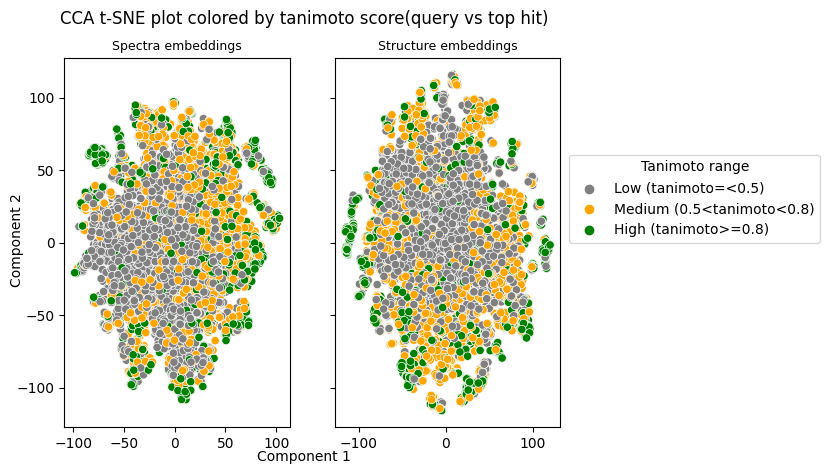

In [58]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.scatterplot(x=x_cca_transformed[:,0],
           y=x_cca_transformed[:,1], hue = category, 
                palette = ['grey', 'orange','green'],
                ax=ax1, legend=False)


sns.scatterplot(x=y_cca_transformed[:,0],
           y=y_cca_transformed[:,1], hue = category,
                palette = ['grey', 'orange','green'],
                )
f.suptitle('CCA t-SNE plot colored by tanimoto score(query vs top hit)', fontsize=12)
ax1.set_title('Spectra embeddings', fontsize=9)
ax2.set_title('Structure embeddings', fontsize=9)
plt.legend(labels=category, loc=(1.04, 0.5))
#ax1.set_ylabel('PC 2', fontsize=15)
f.text(0.5, 0.04, 'Component 1', ha='center')
f.text(0.04, 0.5, 'Component 2', va='center', rotation='vertical')
handles, labels = ax2.get_legend_handles_labels()

ax1.legend(handles, labels, loc= (1.17, 0.5)) # hiding behind ax2 :)
plt.legend(loc= (1.04, 0.5), title ='Tanimoto range')
leg = ax1.legend()
leg.remove()
plt.show()

### Investigate t-SNE when the SDL and CCA used to predict data excluding high scoring queries

##### step 0: load Tanimotos

In [17]:
sdl_tanis = Files('./sdl_768_15_dims/sdl_768_15_dims_cos_tanis_test_df').load_pickle()

# Add Tanis to the Df
test_df['sdl_768_tanimoto'] = sdl_tanis

In [18]:
test_df.head(2)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,cca_z1,cca_z2,sdl_768_z1,sdl_768_z2,sdl_768_tanimoto
5625,COc1ccc(cc1OC)C(=O)NCc2ccc(OCCN(C)C)cc2,QQQIECGTIMUVDS-UHFFFAOYSA-N,QQQIECGTIMUVDS,spec_id5019,"[0.7660381606480904, -2.9954168988462215, -12....","[0.0, 13.000274658203125, 0.35151147842407227,...","[-0.45550603, -3.2559516, -3.0893652, 5.457150...",Benzene and substituted derivatives,"[0.05153173450592052, -0.6290144322197803, 0.3...","[-0.36705695389751064, -0.7741333930770977, 0....","[0.89759576, -0.44103494, 0.25500268, -0.23932...","[0.8142293, -0.8455215, 0.10232448, 0.03982669...",0.3434
40023,COc1cc(OC)c2c(OC)c(-c3ccc4c(c3)OCO4)c(=O)oc2c1,PZYZNVLXKYMURF-UHFFFAOYSA-N,PZYZNVLXKYMURF,spec_id39710,"[4.160680518910307, -17.534900146210205, -20.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 63.7232666015625, 5....","[1.2124093, -3.7327924, -5.30343, 5.8895183, 0...",Isoflavonoids,"[-0.5501047970140038, 0.38237380310465097, 0.3...","[-0.4201982466068921, -0.10796739852068316, -0...","[-1.9857152, 0.01580453, 0.34879375, -0.063378...","[-2.6851432, 0.07175583, 0.100825734, -0.03386...",0.5405


##### step 1: exclude high scoring queries by filtering out queries with  Tanimoto score more than 0.8 

In [19]:
sdl_low_test_df = test_df[test_df['sdl_768_tanimoto'] < 0.8]

#write to file so that I can retransform at the DeepCCA_models script
Files('./sdl_768_15_dims/test_df_excluding_non_high_scoring_queries.pickle').write_to_file(sdl_low_test_df)


# retransform sdl_low_test_df at the DeepCCA_models script; it will write a retransformed df which i load below

retransformed_test_df = Files('./sdl_768_15_dims/retransformed_test_df_excluding_non_high_scoring_queries.pickle').load_pickle()
# you should see 'sdl_exclusion_z1' cols in this df
retransformed_test_df.head(2)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,cca_z1,cca_z2,sdl_768_z1,sdl_768_z2,sdl_768_tanimoto,sdl_exclusion_z1,sdl_exclusion_z2
5625,COc1ccc(cc1OC)C(=O)NCc2ccc(OCCN(C)C)cc2,QQQIECGTIMUVDS-UHFFFAOYSA-N,QQQIECGTIMUVDS,spec_id5019,"[0.7660381606480904, -2.9954168988462215, -12....","[0.0, 13.000274658203125, 0.35151147842407227,...","[-0.45550603, -3.2559516, -3.0893652, 5.457150...",Benzene and substituted derivatives,"[0.05153173450592052, -0.6290144322197803, 0.3...","[-0.36705695389751064, -0.7741333930770977, 0....","[0.89759576, -0.44103494, 0.25500268, -0.23932...","[0.8142293, -0.8455215, 0.10232448, 0.03982669...",0.3434,"[0.91412747, -0.45944878, 0.22894204, -0.27499...","[0.87694925, -0.8284457, 0.11323702, 0.0347905..."
40023,COc1cc(OC)c2c(OC)c(-c3ccc4c(c3)OCO4)c(=O)oc2c1,PZYZNVLXKYMURF-UHFFFAOYSA-N,PZYZNVLXKYMURF,spec_id39710,"[4.160680518910307, -17.534900146210205, -20.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 63.7232666015625, 5....","[1.2124093, -3.7327924, -5.30343, 5.8895183, 0...",Isoflavonoids,"[-0.5501047970140038, 0.38237380310465097, 0.3...","[-0.4201982466068921, -0.10796739852068316, -0...","[-1.9857152, 0.01580453, 0.34879375, -0.063378...","[-2.6851432, 0.07175583, 0.100825734, -0.03386...",0.5405,"[-2.011728, 0.038822383, 0.31981504, -0.077062...","[-2.6763551, 0.09979546, 0.111880705, -0.04374..."


##### step 2: compute cos predictions 

In [30]:
%%time
dim = 15
#size = 5
# compute the cosine distance
dist = predict(subject_df=train_df, subject_method = 'sdl_768',
                        query_df=retransformed_test_df,dims=dim,
                        query_method='sdl_exclusion', metric='cos')


print('\nCalcluting distance is complete\n') 
# use cosine distance to find hits
scores, hit = get_tanimotos(dist,subject_df=train_df,\
                                query_df=retransformed_test_df,\
                                    metric='cos')
print('\nWriting files\n') 
Files('./sdl_768_15_dims/retransformed_sdl_768_15_dim_cos_excluding_highscoring_queries.pickle').write_to_file(dist)                                   
Files('./sdl_768_15_dims/retransformed_sdl_768_15_dim_tanis_excluding_highscoring_queries.pickle').write_to_file(scores[0])
Files('./sdl_768_15_dims/retransformed_sdl_768_15_dim_hits_excluding_highscoring_queries.pickle').write_to_file(hit)



100%|█████████████████████████████████████████████████████████████████████████████| 6578/6578 [2:12:55<00:00,  1.21s/it]



Calcluting distance is complete



100%|███████████████████████████████████████████████████████████████████████████████| 6578/6578 [07:06<00:00, 15.43it/s]



Writing files

CPU times: user 2h 28min 17s, sys: 1min 19s, total: 2h 29min 36s
Wall time: 2h 29min 32s


##### step 3: load computed Tanimotos and hits for non-high-scoring queries 

In [31]:
non_high_scoring_tanis = Files('./sdl_768_15_dims/retransformed_sdl_768_15_dim_tanis_excluding_highscoring_queries.pickle').load_pickle()
non_high_scoring_hits = Files('./sdl_768_15_dims/retransformed_sdl_768_15_dim_hits_excluding_highscoring_queries.pickle').load_pickle()

##### step 4: Add the computed tanis to the df after excluding high scoring queries 

In [41]:
retransformed_test_df['tanis_after_exclusion'] = [x for x in non_high_scoring_tanis]
retransformed_test_df.head(2)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,cca_z1,cca_z2,sdl_768_z1,sdl_768_z2,sdl_768_tanimoto,sdl_exclusion_z1,sdl_exclusion_z2,tanis_after_exclusion
5625,COc1ccc(cc1OC)C(=O)NCc2ccc(OCCN(C)C)cc2,QQQIECGTIMUVDS-UHFFFAOYSA-N,QQQIECGTIMUVDS,spec_id5019,"[0.7660381606480904, -2.9954168988462215, -12....","[0.0, 13.000274658203125, 0.35151147842407227,...","[-0.45550603, -3.2559516, -3.0893652, 5.457150...",Benzene and substituted derivatives,"[0.05153173450592052, -0.6290144322197803, 0.3...","[-0.36705695389751064, -0.7741333930770977, 0....","[0.89759576, -0.44103494, 0.25500268, -0.23932...","[0.8142293, -0.8455215, 0.10232448, 0.03982669...",0.3434,"[0.91412747, -0.45944878, 0.22894204, -0.27499...","[0.87694925, -0.8284457, 0.11323702, 0.0347905...",0.3434
40023,COc1cc(OC)c2c(OC)c(-c3ccc4c(c3)OCO4)c(=O)oc2c1,PZYZNVLXKYMURF-UHFFFAOYSA-N,PZYZNVLXKYMURF,spec_id39710,"[4.160680518910307, -17.534900146210205, -20.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 63.7232666015625, 5....","[1.2124093, -3.7327924, -5.30343, 5.8895183, 0...",Isoflavonoids,"[-0.5501047970140038, 0.38237380310465097, 0.3...","[-0.4201982466068921, -0.10796739852068316, -0...","[-1.9857152, 0.01580453, 0.34879375, -0.063378...","[-2.6851432, 0.07175583, 0.100825734, -0.03386...",0.5405,"[-2.011728, 0.038822383, 0.31981504, -0.077062...","[-2.6763551, 0.09979546, 0.111880705, -0.04374...",0.5405


##### step 5: Run t-SNE 

#### Investigate which molecules are enriched in the high Tanimoto regions

/lustre/BIF/nobackup/lmeli001/miniconda3/envs/cca/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/lustre/BIF/nobackup/lmeli001/miniconda3/envs/cca/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.


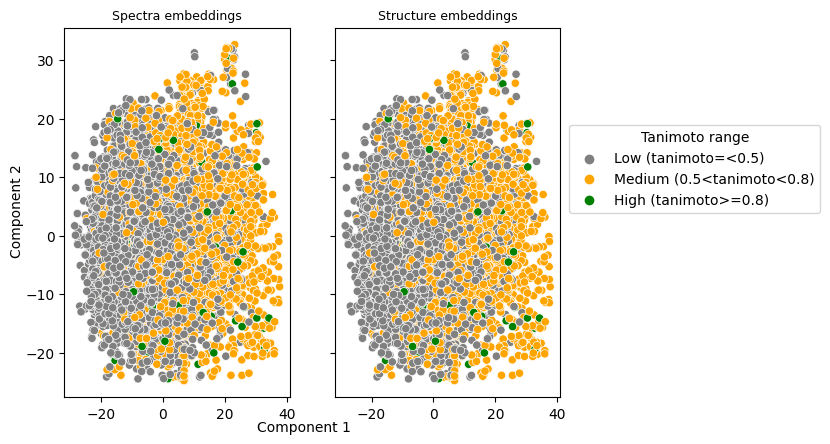

In [63]:
#categories tanis
exclusion_category = group_tanimotos(non_high_scoring_tanis)
retransformed_test_df['sdl_category_exclusion'] = exclusion_category




x_sdl = np.array([i for i in retransformed_test_df['sdl_exclusion_z1']])

y_sdl = np.array([i for i in retransformed_test_df['sdl_exclusion_z2']])


tsne = TSNE(n_components=3, 
            verbose=0, 
            perplexity=10, # assuming these is related to neighbours
            n_iter=1000,
           init = 'pca',
           learning_rate = 'auto'
           )

x_sdl_tsne = tsne.fit_transform(x_sdl)
y_sdl_tsne = tsne.fit_transform(y_sdl)

#plot tsne after for non-high scoring queries
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.scatterplot(x=x_sdl_tsne[:,0],
           y=y_sdl_tsne[:,1], hue = exclusion_category, 
                palette = ['grey', 'orange','green'],
                ax=ax1, legend=False)


sns.scatterplot(x=x_sdl_tsne[:,0],
           y=y_sdl_tsne[:,1], hue = exclusion_category,
                palette = ['grey', 'orange','green'],
                )
#f.suptitle('SDL t-SNE plot colored by tanimoto score(query vs top hit)', fontsize=12)
ax1.set_title('Spectra embeddings', fontsize=9)
ax2.set_title('Structure embeddings', fontsize=9)
plt.legend(labels=exclusion_category, loc=(1.04, 0.5))
#ax1.set_ylabel('PC 2', fontsize=15)
f.text(0.5, 0.04, 'Component 1', ha='center')
f.text(0.04, 0.5, 'Component 2', va='center', rotation='vertical')
handles, labels = ax2.get_legend_handles_labels()

ax1.legend(handles, labels, loc= (1.17, 0.5)) # hiding behind ax2 :)
plt.legend(loc= (1.04, 0.5), title ='Tanimoto range')
leg = ax1.legend()
leg.remove()
plt.show()




No handles with labels found to put in legend.


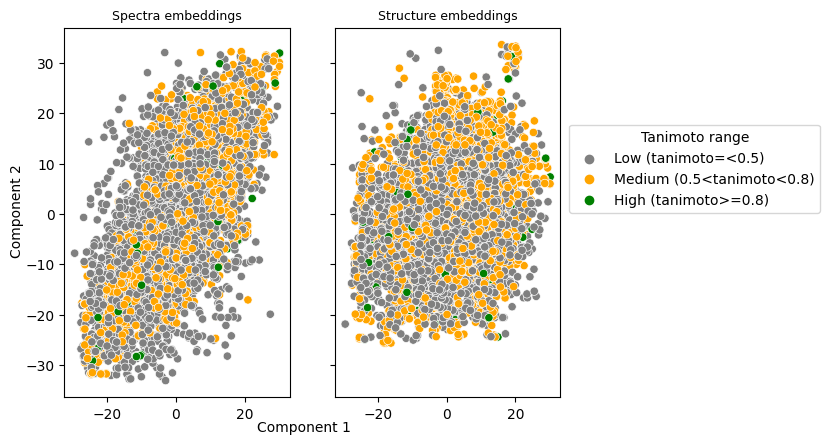

In [62]:
#plot tsne after for non-high scoring queries
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.scatterplot(x=x_sdl_tsne[:,1],
           y=y_sdl_tsne[:,2], hue = exclusion_category, 
                palette = ['grey', 'orange','green'],
                ax=ax1, legend=False)


sns.scatterplot(x=x_sdl_tsne[:,1],
           y=y_sdl_tsne[:,1], hue = exclusion_category,
                palette = ['grey', 'orange','green'],
                )
#f.suptitle('SDL t-SNE plot colored by tanimoto score(query vs top hit)', fontsize=12)
ax1.set_title('Spectra embeddings', fontsize=9)
ax2.set_title('Structure embeddings', fontsize=9)
plt.legend(labels=exclusion_category, loc=(1.04, 0.5))
#ax1.set_ylabel('PC 2', fontsize=15)
f.text(0.5, 0.04, 'Component 1', ha='center')
f.text(0.04, 0.5, 'Component 2', va='center', rotation='vertical')
handles, labels = ax2.get_legend_handles_labels()

ax1.legend(handles, labels, loc= (1.17, 0.5)) # hiding behind ax2 :)
plt.legend(loc= (1.04, 0.5), title ='Tanimoto range')
leg = ax1.legend()
leg.remove()
plt.show()


#### Investigate which molecules are enriched in the high Tanimoto regions

In [26]:
# select classes under each category
high_class = test_df.loc[test_df['category'] == 'High (tanimoto>=0.8)']
medium_class = test_df.loc[test_df['category'] == 'Medium (0.5<tanimoto<0.8)']
low_class = test_df.loc[test_df['category'] == 'Low (tanimoto=<0.5)']
print(len(high_class),len(medium_class),len(low_class))

1712 2465 4113


### Fisher_exact test

This follows scipy.stats.fisher_exact test [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html)

1. High scoring queries

In [35]:
yes_no = []
for score in test_df['category']:
    if score == 'High (tanimoto>=0.8)':
        yes_no.append('yes')
    else:
         yes_no.append('no')
test_df['group'] = [x for x in yes_no] 

In [36]:
table_df = test_df[['cf_class', 'group']]
table_df.shape

(8290, 2)

In [37]:
#creat contigency table for all classes
levels = [x for x in table_df['group']] # yes if high tanimoto, no if else
cf_class = [x for x in table_df['cf_class']]

(xclass, xlevels),count = crosstab(cf_class, levels)
count.shape

(250, 2)

In [39]:
xlevels

array(['no', 'yes'], dtype='<U3')

In [40]:
count[:5] #column1 == not high score,column2 == yes success(high score)

array([[ 2,  1],
       [18,  0],
       [ 2,  0],
       [ 2,  2],
       [ 1,  0]])

In [41]:
# fisher_eaxct test
metric = 'cos'
pval = []
M = count.sum()
class_total =[]
class_identified = []
success_rate = []
unsuccess_rate= [] # running out of variable names :)
all_success = []
all_unsuccess = []
for i in range(len(count)):
    x = count[i][1] # success for one class 
    n = count[i].sum() # total for one class
    n_x = n-x # no success for one class
    N = count[:,1].sum() #success for all classes
    N_x = N - x # total success minus x

    table = [[x, n_x], [N_x, (M - (n + N) + x)]]
    ods, p = fisher_exact(table) # two-sided ?
    pval.append(p)
    success_rate.append((x/n))
    unsuccess_rate.append((n_x/n))
    class_total.append(n)
    all_success.append((x/N))
    all_unsuccess.append((n_x/(M-N)))
    class_identified.append(x)

#creat df
high_enriched_df = pd.DataFrame({'cf_class':[x for x in xclass],
                            'pvalue':[x for x in pval],
                            'class_total': [x for x in class_total],
                            '#_high_tanimoto': [x for x in class_identified],
                           'ratio_class_high_tanimoto': [x for x in success_rate],
                           'ratio_class_not_high_tanimoto': [x for x in unsuccess_rate],
                            'high_tanimoto': [x for x in all_success],
                            'not_high_tanimoto': [x for x in all_unsuccess]}
                            
                          )

high_enriched_df = high_enriched_df.sort_values(['pvalue','ratio_class_high_tanimoto'],
                                                ascending = [True, False])
Files(f'./sdl_768_15_dims/high_scoring_hits_by_{metric}_distance').write_to_file(high_enriched_df)
high_enriched_df.head(10)

,cf_class,pvalue,class_total,#_high_tanimoto,ratio_class_high_tanimoto,ratio_class_not_high_tanimoto,high_tanimoto,not_high_tanimoto
99,Glycerophospholipids,8.473542e-56,136,113,0.830882,0.169118,0.066005,0.003497
98,Glycerolipids,1.729303e-45,94,83,0.882979,0.117021,0.048481,0.001672
28,Benzene and substituted derivatives,6.661315e-36,729,36,0.049383,0.950617,0.021028,0.105351
249,nan,2.381089e-33,265,142,0.535849,0.464151,0.082944,0.018699
90,Flavonoids,1.215545e-24,441,183,0.414966,0.585034,0.106893,0.039222
13,Aporphines,6.723280e-09,42,26,0.619048,0.380952,0.015187,0.002432
212,Sphingolipids,9.831863e-08,33,21,0.636364,0.363636,0.012266,0.001824
135,Macroline alkaloids,3.265486e-06,8,8,1.000000,0.000000,0.004673,0.000000
165,Peptidomimetics,4.683375e-05,153,53,0.346405,0.653595,0.030958,0.015202
138,Naphthalenes,5.530023e-04,36,0,0.000000,1.000000,0.000000,0.005473


2. Low scoring queries

In [42]:
#categories
yes_no = []
for score in test_df['category']:
    if score == 'Low (tanimoto=<0.5)':
        yes_no.append('yes')
    else:
         yes_no.append('no')
test_df['group_low'] = [x for x in yes_no] 
table_df = test_df[['cf_class', 'group_low']]

In [43]:
#create contigency table for the low scoring queries ::: will create one function for this

levels = [x for x in table_df['group_low']] # yes if high tanimoto, no if else
cf_class = [x for x in table_df['cf_class']]

(xclass, xlevels),count_low = crosstab(cf_class, levels)
count_low.shape

(250, 2)

In [44]:
xlevels

array(['no', 'yes'], dtype='<U3')

In [45]:
count_low[:5] # col 1 not low score; col 2 low score

array([[ 3,  0],
       [13,  5],
       [ 0,  2],
       [ 2,  2],
       [ 0,  1]])

In [46]:
# fisher_eaxct test for the low scoring queries

pval = []
M = count.sum()
class_total =[]
class_low = []
success_rate = []
unsuccess_rate= [] # running out of variable names :)
all_success = []
all_unsuccess = []
for i in range(len(count_low)):
    x = count_low[i][1] # success for one class 
    n = count_low[i].sum() # total for one class
    n_x = n-x # no success for one class
    N = count_low[:,1].sum() #success for all classes
    N_x = N - x # total success minus x

    table = [[x, n_x], [N_x, (M - (n + N) + x)]]
    ods, p = fisher_exact(table) 
    pval.append(p)
    success_rate.append((x/n))
    unsuccess_rate.append((n_x/n))
    class_total.append(n)
    class_low.append(x)
    all_success.append((x/N))
    all_unsuccess.append((n_x/(M-N)))

#create low enriched df
low_enriched_df = pd.DataFrame({'cf_class':[x for x in xclass],
                            'pvalue':[x for x in pval],
                            'class_total': [x for x in class_total],
                            '#_low_tanimoto': [x for x in class_low],
                           'ratio_class_low_tanimoto': [x for x in success_rate],
                           'ratio_class_not_low_tanimoto': [x for x in unsuccess_rate],
                            'ratio_all_low_tanimoto': [x for x in all_success],
                            'ratio_all_not_low_tanimoto': [x for x in all_unsuccess]}
                          )

low_enriched_df = low_enriched_df.sort_values(['pvalue','ratio_class_low_tanimoto'],
                                                ascending = [True, False])
low_enriched_df.head(10)

Files(f'./sdl_768_15_dims/low_scoring_hits_by_{metric}_distance').write_to_file(low_enriched_df)

In [47]:
#drop some columns that arent useful in heatmap
new_df_high = high_enriched_df.drop(columns=['cf_class', 
                                             'class_total',
                                             'pvalue',
                                             'ratio_class_high_tanimoto',
                                             'ratio_class_not_high_tanimoto',
                                             '#_high_tanimoto'])
new_df_low = low_enriched_df.drop(columns=['cf_class', 'class_total', '#_low_tanimoto'])

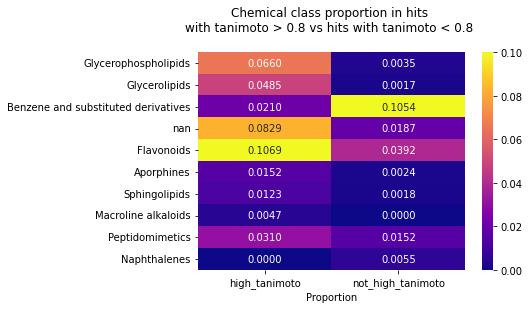

In [50]:
lab = [x for x in high_enriched_df['cf_class'].head(10)]
sns.heatmap(new_df_high.head(10), yticklabels = lab, vmin=0, vmax=0.1,cmap="plasma",
          annot=True, fmt=".4f")
plt.title('Chemical class proportion in hits \nwith tanimoto > 0.8 vs hits with tanimoto < 0.8 \n')
plt.savefig(f'./sdl_768_15_dims/heatmap_high_scoring_hits_by_{metric}_distance',bbox_inches = 'tight')
plt.xlabel('Proportion')
plt.show()

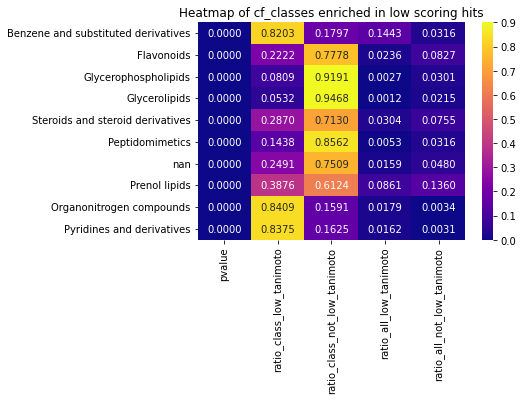

In [159]:
# for discussion the above captures enough info
lab = [x for x in low_enriched_df['cf_class'].head(10)]
sns.heatmap(new_df_low.head(10), yticklabels = lab, vmin=0, vmax=0.9,cmap="plasma",
          annot=True, fmt=".4f")
plt.title('Heatmap of cf_classes enriched in low scoring hits')
plt.savefig(f'./sdl_768_15_dims/heatmap_low_scoring_hits_by_{metric}_distance',bbox_inches = 'tight')
plt.show()

#### Draw a few random Mols from Glyecrolipids

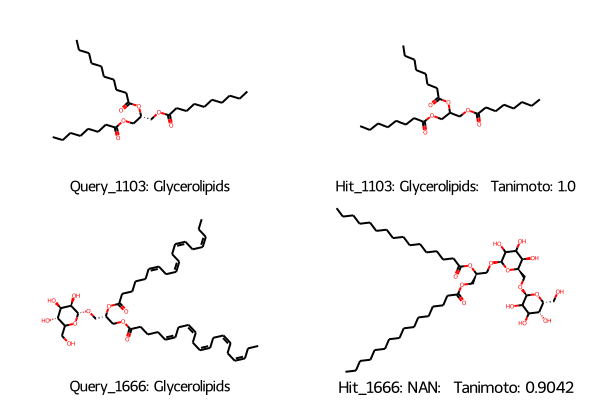

In [141]:
sdl_glycerols_query_mols, sdl_glycerols_hits_mols, query_legend, hit_legend = pick_hit_mols(sdl_hits,train_df,test_df,
          group=['Glycerolipids'],
           return_tanimoto=False,
           filterby='cf_class')

# randomly pick a mol and its legend

rand_indices = random.sample(range(0, len(sdl_glycerols_query_mols)), 2)

mols = []
legends = []
for x in rand_indices:
    mols.append(sdl_glycerols_query_mols[x]) #just putting them in same list for ease of drawing
    mols.append(sdl_glycerols_hits_mols[x])
    legends.append(query_legend[x])
    legends.append(hit_legend[x])

Draw.MolsToGridImage(mols,
                        molsPerRow=2, 
                        legends = legends,
                        subImgSize=(300,200),
                                returnPNG=True)



#### Draw a few random Mols from Glyecrophospholipids

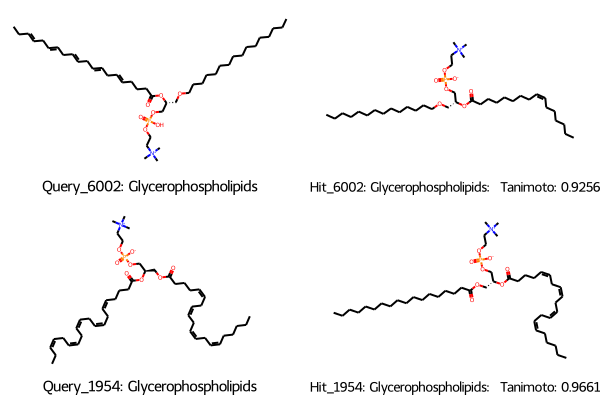

In [132]:
sdl_glyphospho_query_mols, sdl_glyphospho_hits_mols, query_legend, hit_legend = pick_hit_mols(sdl_hits,train_df,test_df,
          group=['Glycerophospholipids'],
           return_tanimoto=False,
           filterby='cf_class')

# randomly pick a mol and its legend

rand_indices = random.sample(range(0, len(sdl_glyphospho_query_mols)), 2)

mols = []
legends = []
for x in rand_indices:
    mols.append(sdl_glyphospho_query_mols[x]) #just putting them in same list for ease of drawing
    mols.append(sdl_glyphospho_hits_mols[x])
    legends.append(query_legend[x])
    legends.append(hit_legend[x])

Draw.MolsToGridImage(mols,
                        molsPerRow=2, 
                        legends = legends,
                        subImgSize=(300,200),
                                returnPNG=True)


#### Draw a few random Mols from Benzenes and Derivatives

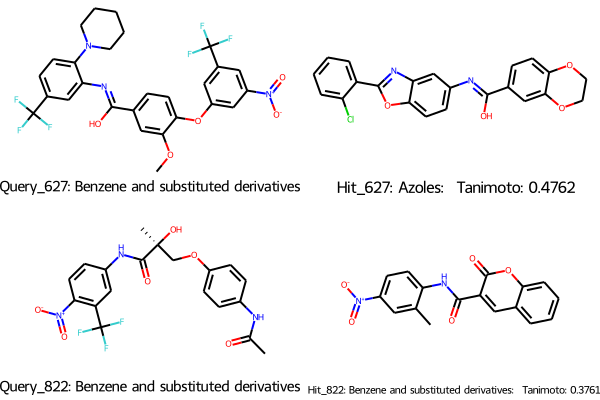

In [138]:
sdl_benzenes_query_mols, sdl_benzenes_hits_mols, query_legend, hit_legend = pick_hit_mols(sdl_hits,train_df,test_df,
          group=['Benzene and substituted derivatives'],
           return_tanimoto=False,
           filterby='cf_class')

# randomly pick a mol and its legend

rand_indices = random.sample(range(0, len(sdl_benzenes_query_mols)), 2)

mols = []
legends = []
for x in rand_indices:
    mols.append(sdl_benzenes_query_mols[x]) #just putting them in same list for ease of drawing
    mols.append(sdl_benzenes_hits_mols[x])
    legends.append(query_legend[x])
    legends.append(hit_legend[x])

Draw.MolsToGridImage(mols,
                        molsPerRow=2, 
                        legends = legends,
                        subImgSize=(300,200),
                                returnPNG=True)


#### Never mind the codes below; you have reached the end of important codes

In [310]:
#random drawing for top 5 hits

# #randomly pick a query
# keys = random.sample(test_cca_corr_tanimotos.keys(),5)
# sample_dict = {key: test_cca_corr_tanimotos[key] for key in keys}

# #draw select top 5 hits
# all_mols = []
# #scores = []
# mol_classes = []
# #os.chdir('../compounds')
# for query_index, values in tqdm(sample_dict.items()):
#     top_hits = np.sort(values)[:5]
#     tanimotos = []
    
#     #draw the query
    
#     query_smile= val_df['smiles'].iloc[query_index]
#     query_class = val_df['cf_class'].iloc[query_index]
#     if type(query_class) == float:
#         query_class = 'NAN'
#         classes = [f'Query:\t{query_class}',]
#     classes = [f'QUERY:\t{query_class}',]
#     query = Chem.MolFromSmiles(query_smile)
#     #Draw.MolToFile(query, f"dcca_max_corr_query_{query_index}_{query_class}.png")
#     #Draw.MolsToGridImage(query)
#     #draw top 5 hits
#     subjects = [query,]
#     for hit_index, hit in enumerate(top_hits):
#         subject_index = values.index(hit)
#         subject_smile = train_df['smiles'].iloc[subject_index]
        
        
#         subject = Chem.MolFromSmiles(subject_smile)
#         subjects.append(subject)
#         #Draw.MolToFile(subject, f"dcca_max_corr_query_{query_index}_hit_{hit_index}_{subject_class}.png")
#         cl = train_df['cf_class'].iloc[subject_index]
#         if type(cl) == float:
#             cl = 'NAN'
#             subject_class = f'\tHit_{hit_index}\t{cl}:\nTanimoto:\t{tanimoto(query_smile,subject_smile)}'
#             classes.append(subject_class)
#         else:
#             subject_class = f'\tHit_{hit_index}\t{cl}:\nTanimoto:\t{tanimoto(query_smile,subject_smile)}'
#             classes.append(subject_class)
#         #check tanimotos for the random selections
#         tanimotos.append(tanimoto(query_smile,subject_smile))
#    # scores.append([(query_index,query_class),tanimotos])
#     all_mols.append(subjects)
#     mol_classes.append(classes)


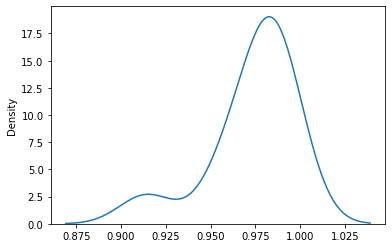

In [312]:
ax=sns.kdeplot(x=corr,shade=False)

In [ ]:
for key, values in sample_dict.items():
    print(key,max(values))
    print(np.sort(values)[::-1][0:5])